## Imports

In [2]:
import os
import math
import obspy
import pickle
import datetime
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
from scipy.optimize import curve_fit
from datetime import timedelta
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

from earthquake import earthquake
import util
import pandas as pd

## Get set up
Set path to data, and read eq_list (all folders in root folder)

In [3]:
root = '/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/'

eq_list = os.listdir(root)

Open catalog of events

In [4]:
client = Client("IRIS")
# cat = client.get_events(starttime=UTCDateTime("2019-01-01"), endtime=UTCDateTime("2020-01-01"), minmagnitude=5, includearrivals=True)
cat = obspy.read_events('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3_catalog.xml')

Not all events had suitable data, look through all events and make a list of ones which have data (eq_with_data) and were successfully picked

In [5]:
eq_with_data = []
cat_with_data = cat.copy()
cat_with_data.clear()
for event in cat:
    eq_name = util.catEventToFileName(event)
    if os.path.isdir(root+eq_name) and os.path.isdir(root+eq_name+'/station_xml_files') and os.path.exists(root+eq_name+'/picks.pkl'):
        eq_with_data.append(eq_name)
        cat_with_data.extend([event])

In [6]:
#len(cat_with_data)

In [6]:
#cat.plot()


In [7]:
#cat_with_data.plot()

In [8]:
%%script false --no-raise-error
cat[0].magnitudes[0].mag
mags = []
mags_d = []
for e in cat:
    mags.append(e.magnitudes[0].mag)
for e in cat_with_data:
    mags_d.append(e.magnitudes[0].mag)    
plt.hist(mags, np.arange(3, 8, 0.1))
plt.hist(mags_d, np.arange(3, 8, 0.1))
plt.yscale('log')

In [347]:
e.magnitudes

[Magnitude
	    resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?magnitudeid=192468205")
	            mag: 4.5
	 magnitude_type: 'mb'
	  creation_info: CreationInfo(author='us')]

In [349]:
body = 0
local = 0
revised_local = 0
moment = 0
mwr = 0
md = 0
other = 0
l = []
for e in cat:
    m = e.magnitudes[0].mag
    mt = e.magnitudes[0].magnitude_type.lower()
    #print(mt)
    if mt == 'mb' or mt == 'mb_lg':
        body += 1
    elif mt == 'ml':
        local += 1
    elif mt == 'mlr':
        revised_local += 1
    elif mt == 'md':
        md += 1
    elif mt == 'mww' or mt == 'mwr' or mt == 'mw' or mt == 'mwb':
        moment += 1
    else:
        other += 1
        print(mt)
    l.append([m, mt])
print(body, local, revised_local, moment, md, other)

ms_20
mh
9064 2574 85 1507 684 2


In [350]:
import csv
with open('/home/earthquakes1/homes/Rebecca/phd/data/mag-dist.csv', 'w') as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
    
    write.writerows(l)

## the action!!
For all events with data, load the data and then create an earthquake object. work out tp_max and tc, and add to lists (for plotting)

In [12]:
list_tpmax = []
list_mags = []
list_tc= []
list_eq = []
eqs = {}
count = 0
max_radius_km = 100
for eq_name in eq_with_data[0:3000]:
    
    d = util.filenameToDate(eq_name)
    
    filter_start = str(UTCDateTime(d-timedelta(seconds=1)))
    filter_stop = str(UTCDateTime(d+timedelta(seconds=1)))
    
    event = cat.filter('time > ' + filter_start, 'time < ' + filter_stop)
    # print(event)
    data = obspy.read(root+eq_name+'/data/*/*')
    inv = obspy.read_inventory(root+eq_name+'/station_xml_files/*')
    try:
        data.remove_response(inv)
    except:
        eq_with_data.remove(eq_name)
        count += 1
        continue
    with open(root+eq_name+'/picks.pkl', 'rb') as f:
        picks = pickle.load(f)
    obj_name = eq_name[0:-2]
    data_nearby = util.find_nearby_data(data, inv, event[0], max_radius_km)
    eqs[obj_name] = earthquake(eq_name, event, data_nearby, picks, sensor_types = [])
    eqs[obj_name].calc_Tpmax()
    eqs[obj_name].calc_Tc()
    list_tpmax.append(eqs[obj_name]._cached_params["tau_p_max"])
    list_tc.append(eqs[obj_name]._cached_params["tau_c"])
    list_mags.append(eqs[obj_name].event.magnitudes[0].mag)
    list_eq.append(eq_name)
    print('earthquake number ' + str(count) + ' of '+ str(len(eq_with_data)) + ' done. It was ' + eq_name)
    count += 1

earthquake number 0 of 3386 done. It was 20190131_194949.a
earthquake number 1 of 3386 done. It was 20190131_130953.a
earthquake number 2 of 3386 done. It was 20190131_130350.a
earthquake number 3 of 3386 done. It was 20190131_101656.a
earthquake number 4 of 3386 done. It was 20190131_085520.a
earthquake number 5 of 3386 done. It was 20190131_082011.a
earthquake number 6 of 3386 done. It was 20190131_054201.a
earthquake number 7 of 3386 done. It was 20190131_044030.a
earthquake number 8 of 3386 done. It was 20190131_035250.a
earthquake number 9 of 3386 done. It was 20190131_031714.a
earthquake number 10 of 3386 done. It was 20190131_031336.a
earthquake number 11 of 3386 done. It was 20190131_001648.a
earthquake number 12 of 3386 done. It was 20190130_231259.a
earthquake number 13 of 3386 done. It was 20190130_225434.a
earthquake number 14 of 3386 done. It was 20190130_221651.a
earthquake number 15 of 3386 done. It was 20190130_210253.a
earthquake number 16 of 3386 done. It was 20190130

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 76 of 3386 done. It was 20190124_141219.a
earthquake number 77 of 3386 done. It was 20190124_131330.a
earthquake number 78 of 3386 done. It was 20190124_123034.a
earthquake number 79 of 3386 done. It was 20190124_121517.a
earthquake number 80 of 3386 done. It was 20190124_112024.a
earthquake number 81 of 3386 done. It was 20190124_102829.a
earthquake number 82 of 3386 done. It was 20190124_080610.a
earthquake number 83 of 3386 done. It was 20190124_030457.a
earthquake number 84 of 3386 done. It was 20190124_001614.a
earthquake number 85 of 3386 done. It was 20190123_213423.a
earthquake number 86 of 3386 done. It was 20190123_132806.a
earthquake number 87 of 3386 done. It was 20190123_130902.a
earthquake number 88 of 3386 done. It was 20190123_112256.a
earthquake number 89 of 3386 done. It was 20190123_100900.a
earthquake number 90 of 3386 done. It was 20190123_054148.a
earthquake number 91 of 3386 done. It was 20190123_040056.a
earthquake number 92 of 3386 done. It wa

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/mseed/headers.py:828: InternalMSEEDWarning: CZ_MORC__HHE_D: Warning: Number of blockettes in fixed header (1) does not match the number parsed (2)
  warnings.warn(_w, InternalMSEEDWarning)
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/mseed/headers.py:828: InternalMSEEDWarning: CZ_MORC__HHN_D: Warning: Number of blockettes in fixed header (1) does not match the number parsed (2)
  warnings.warn(_w, InternalMSEEDWarning)
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/mseed/headers.py:828: InternalMSEEDWarning: CZ_MORC__HHZ_D: Warning: Number of blockettes in fixed header (1) does not match the number parsed (2)
  warnings.warn(_w, InternalMSEEDWarning)
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/mseed/headers.py:828: InternalMSEEDWarning: GE_MORC__HHE_D: Warning: Number of blockettes in fixed header (1) does not match the number parsed (2

earthquake number 94 of 3386 done. It was 20190122_223529.a
earthquake number 95 of 3386 done. It was 20190122_213050.a
earthquake number 96 of 3386 done. It was 20190122_201206.a
earthquake number 97 of 3386 done. It was 20190122_161926.a
earthquake number 98 of 3386 done. It was 20190122_152200.a
earthquake number 99 of 3386 done. It was 20190122_150049.a
earthquake number 100 of 3386 done. It was 20190122_134447.a
earthquake number 101 of 3386 done. It was 20190122_103750.a
earthquake number 102 of 3386 done. It was 20190122_082446.a
earthquake number 103 of 3386 done. It was 20190122_082444.a
earthquake number 104 of 3386 done. It was 20190122_045611.a
earthquake number 105 of 3386 done. It was 20190122_044319.a
earthquake number 106 of 3386 done. It was 20190122_043311.a
earthquake number 107 of 3386 done. It was 20190122_031928.a
earthquake number 108 of 3386 done. It was 20190122_022514.a
earthquake number 109 of 3386 done. It was 20190122_015034.a
earthquake number 110 of 3386 

/home/earthquakes1/homes/Rebecca/phd/seismo_det/code/earthquake.py:105: RuntimeWarning: invalid value encountered in true_divide
  tau_p = 2 * np.pi * np.sqrt(X/D)
/home/earthquakes1/homes/Rebecca/phd/seismo_det/code/earthquake.py:195: RuntimeWarning: invalid value encountered in double_scalars
  t_c = (2 * math.pi)/(math.sqrt(numerator/denominator))


earthquake number 118 of 3386 done. It was 20190121_052736.a
earthquake number 119 of 3386 done. It was 20190121_041101.a
earthquake number 120 of 3386 done. It was 20190121_003254.a
earthquake number 121 of 3386 done. It was 20190121_000918.a
earthquake number 122 of 3386 done. It was 20190120_214851.a
earthquake number 123 of 3386 done. It was 20190120_174954.a
earthquake number 124 of 3386 done. It was 20190120_174641.a
earthquake number 125 of 3386 done. It was 20190120_154950.a
earthquake number 126 of 3386 done. It was 20190120_145534.a
earthquake number 127 of 3386 done. It was 20190120_140529.a
earthquake number 128 of 3386 done. It was 20190120_132422.a
earthquake number 129 of 3386 done. It was 20190120_113202.a
earthquake number 130 of 3386 done. It was 20190120_104359.a
earthquake number 131 of 3386 done. It was 20190120_103922.a
earthquake number 132 of 3386 done. It was 20190120_092332.a
earthquake number 133 of 3386 done. It was 20190120_073927.a
earthquake number 134 of

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 144 of 3386 done. It was 20190119_041429.a
earthquake number 145 of 3386 done. It was 20190119_023613.a
earthquake number 146 of 3386 done. It was 20190118_191237.a
earthquake number 147 of 3386 done. It was 20190118_185231.a
earthquake number 148 of 3386 done. It was 20190118_171414.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 149 of 3386 done. It was 20190118_165907.a
earthquake number 150 of 3386 done. It was 20190118_152205.a
earthquake number 151 of 3386 done. It was 20190118_150253.a
earthquake number 152 of 3386 done. It was 20190118_140846.a
earthquake number 153 of 3386 done. It was 20190118_124624.a
earthquake number 154 of 3386 done. It was 20190118_123408.a
earthquake number 155 of 3386 done. It was 20190118_114754.a
earthquake number 156 of 3386 done. It was 20190118_113801.a
earthquake number 157 of 3386 done. It was 20190118_081915.a
earthquake number 158 of 3386 done. It was 20190118_063650.a
earthquake number 159 of 3386 done. It was 20190118_055247.a
earthquake number 160 of 3386 done. It was 20190118_054634.a
earthquake number 161 of 3386 done. It was 20190118_040520.a
earthquake number 162 of 3386 done. It was 20190118_000748.a
earthquake number 163 of 3386 done. It was 20190117_214639.a
earthquake number 164 of 3386 done. It was 20190117_173039.a
earthquake number 165 of

/home/earthquakes1/homes/Rebecca/phd/seismo_det/code/earthquake.py:105: RuntimeWarning: invalid value encountered in true_divide
  tau_p = 2 * np.pi * np.sqrt(X/D)
/home/earthquakes1/homes/Rebecca/phd/seismo_det/code/earthquake.py:195: RuntimeWarning: invalid value encountered in double_scalars
  t_c = (2 * math.pi)/(math.sqrt(numerator/denominator))


earthquake number 189 of 3386 done. It was 20190116_033430.a
earthquake number 190 of 3386 done. It was 20190116_011111.a
earthquake number 191 of 3386 done. It was 20190116_003933.a
earthquake number 192 of 3386 done. It was 20190115_222405.a
earthquake number 193 of 3386 done. It was 20190115_212334.a
earthquake number 194 of 3386 done. It was 20190115_202146.a
earthquake number 195 of 3386 done. It was 20190115_202137.a
earthquake number 196 of 3386 done. It was 20190115_202020.a
earthquake number 197 of 3386 done. It was 20190115_164442.a
earthquake number 198 of 3386 done. It was 20190115_154052.a


/home/earthquakes1/homes/Rebecca/phd/seismo_det/code/earthquake.py:105: RuntimeWarning: invalid value encountered in true_divide
  tau_p = 2 * np.pi * np.sqrt(X/D)
/home/earthquakes1/homes/Rebecca/phd/seismo_det/code/earthquake.py:195: RuntimeWarning: invalid value encountered in double_scalars
  t_c = (2 * math.pi)/(math.sqrt(numerator/denominator))


earthquake number 199 of 3386 done. It was 20190115_133202.a


/home/earthquakes1/homes/Rebecca/phd/seismo_det/code/earthquake.py:105: RuntimeWarning: invalid value encountered in true_divide
  tau_p = 2 * np.pi * np.sqrt(X/D)
/home/earthquakes1/homes/Rebecca/phd/seismo_det/code/earthquake.py:195: RuntimeWarning: invalid value encountered in double_scalars
  t_c = (2 * math.pi)/(math.sqrt(numerator/denominator))


earthquake number 200 of 3386 done. It was 20190115_132802.a
earthquake number 201 of 3386 done. It was 20190115_034104.a
earthquake number 202 of 3386 done. It was 20190115_031053.a
earthquake number 203 of 3386 done. It was 20190115_013102.a
earthquake number 204 of 3386 done. It was 20190115_012504.a
earthquake number 205 of 3386 done. It was 20190115_001840.a
earthquake number 206 of 3386 done. It was 20190114_230356.a
earthquake number 207 of 3386 done. It was 20190114_224808.a
earthquake number 208 of 3386 done. It was 20190114_223228.a
earthquake number 209 of 3386 done. It was 20190114_205104.a
earthquake number 210 of 3386 done. It was 20190114_204906.a
earthquake number 211 of 3386 done. It was 20190114_192938.a
earthquake number 212 of 3386 done. It was 20190114_190014.a
earthquake number 213 of 3386 done. It was 20190114_184920.a
earthquake number 214 of 3386 done. It was 20190114_142313.a
earthquake number 215 of 3386 done. It was 20190114_134942.a
earthquake number 216 of

/home/earthquakes1/homes/Rebecca/phd/seismo_det/code/earthquake.py:105: RuntimeWarning: invalid value encountered in true_divide
  tau_p = 2 * np.pi * np.sqrt(X/D)
/home/earthquakes1/homes/Rebecca/phd/seismo_det/code/earthquake.py:195: RuntimeWarning: invalid value encountered in double_scalars
  t_c = (2 * math.pi)/(math.sqrt(numerator/denominator))


earthquake number 217 of 3386 done. It was 20190114_082007.a
earthquake number 218 of 3386 done. It was 20190114_042341.a
earthquake number 219 of 3386 done. It was 20190114_040230.a
earthquake number 220 of 3386 done. It was 20190114_032019.a
earthquake number 221 of 3386 done. It was 20190114_010658.a
earthquake number 222 of 3386 done. It was 20190114_004119.a
earthquake number 223 of 3386 done. It was 20190113_182825.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 224 of 3386 done. It was 20190113_180454.a
earthquake number 225 of 3386 done. It was 20190113_164555.a
earthquake number 226 of 3386 done. It was 20190113_132319.a
earthquake number 227 of 3386 done. It was 20190113_121445.a
earthquake number 228 of 3386 done. It was 20190113_105401.a
earthquake number 229 of 3386 done. It was 20190113_093548.a
earthquake number 230 of 3386 done. It was 20190113_082701.a
earthquake number 231 of 3386 done. It was 20190113_065210.a
earthquake number 232 of 3386 done. It was 20190113_064530.a
earthquake number 233 of 3386 done. It was 20190112_204035.a
earthquake number 234 of 3386 done. It was 20190112_185104.a
earthquake number 235 of 3386 done. It was 20190112_171406.a
earthquake number 236 of 3386 done. It was 20190112_132011.a
earthquake number 237 of 3386 done. It was 20190112_111903.a
earthquake number 238 of 3386 done. It was 20190112_085826.a
earthquake number 239 of 3386 done. It was 20190112_063152.a
earthquake number 240 of

/home/earthquakes1/homes/Rebecca/phd/seismo_det/code/earthquake.py:105: RuntimeWarning: invalid value encountered in true_divide
  tau_p = 2 * np.pi * np.sqrt(X/D)
/home/earthquakes1/homes/Rebecca/phd/seismo_det/code/earthquake.py:195: RuntimeWarning: invalid value encountered in double_scalars
  t_c = (2 * math.pi)/(math.sqrt(numerator/denominator))


earthquake number 294 of 3386 done. It was 20190107_164307.a
earthquake number 295 of 3386 done. It was 20190107_161457.a
earthquake number 296 of 3386 done. It was 20190107_151727.a
earthquake number 297 of 3386 done. It was 20190107_134329.a
earthquake number 298 of 3386 done. It was 20190107_134132.a
earthquake number 299 of 3386 done. It was 20190107_124804.a
earthquake number 300 of 3386 done. It was 20190107_121052.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 301 of 3386 done. It was 20190107_035322.a
earthquake number 302 of 3386 done. It was 20190107_014455.a
earthquake number 303 of 3386 done. It was 20190107_000252.a
earthquake number 304 of 3386 done. It was 20190106_202536.a
earthquake number 305 of 3386 done. It was 20190106_190135.a
earthquake number 306 of 3386 done. It was 20190106_184430.a
earthquake number 307 of 3386 done. It was 20190106_181231.a
earthquake number 308 of 3386 done. It was 20190106_134425.a
earthquake number 309 of 3386 done. It was 20190106_123609.a
earthquake number 310 of 3386 done. It was 20190106_113653.a
earthquake number 311 of 3386 done. It was 20190106_111934.a
earthquake number 312 of 3386 done. It was 20190106_103830.a
earthquake number 313 of 3386 done. It was 20190106_101442.a
earthquake number 314 of 3386 done. It was 20190106_090803.a
earthquake number 315 of 3386 done. It was 20190106_035624.a
earthquake number 316 of 3386 done. It was 20190106_034658.a
earthquake number 317 of

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 339 of 3386 done. It was 20190104_035047.a
earthquake number 340 of 3386 done. It was 20190104_023035.a
earthquake number 341 of 3386 done. It was 20190103_225921.a
earthquake number 342 of 3386 done. It was 20190103_205526.a
earthquake number 343 of 3386 done. It was 20190103_185138.a
earthquake number 344 of 3386 done. It was 20190103_180250.a
earthquake number 345 of 3386 done. It was 20190103_175746.a
earthquake number 346 of 3386 done. It was 20190103_152256.a
earthquake number 347 of 3386 done. It was 20190103_120522.a
earthquake number 348 of 3386 done. It was 20190103_091028.a
earthquake number 349 of 3386 done. It was 20190103_053338.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 350 of 3386 done. It was 20190103_050711.a
earthquake number 351 of 3386 done. It was 20190103_033213.a
earthquake number 352 of 3386 done. It was 20190103_021456.a
earthquake number 353 of 3386 done. It was 20190103_015635.a
earthquake number 354 of 3386 done. It was 20190103_000409.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 355 of 3386 done. It was 20190102_212030.a
earthquake number 356 of 3386 done. It was 20190102_203004.a
earthquake number 357 of 3386 done. It was 20190102_190921.a
earthquake number 358 of 3386 done. It was 20190102_163248.a
earthquake number 359 of 3386 done. It was 20190102_151603.a
earthquake number 360 of 3386 done. It was 20190102_113856.a
earthquake number 361 of 3386 done. It was 20190102_111532.a
earthquake number 362 of 3386 done. It was 20190102_111215.a
earthquake number 363 of 3386 done. It was 20190102_094251.a
earthquake number 364 of 3386 done. It was 20190102_093616.a
earthquake number 365 of 3386 done. It was 20190102_074020.a
earthquake number 366 of 3386 done. It was 20190102_064856.a
earthquake number 367 of 3386 done. It was 20190102_064843.a
earthquake number 368 of 3386 done. It was 20190102_022456.a
earthquake number 369 of 3386 done. It was 20190102_014046.a
earthquake number 370 of 3386 done. It was 20190101_220539.a
earthquake number 371 of

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 390 of 3386 done. It was 20190228_195534.a
earthquake number 391 of 3386 done. It was 20190228_181706.a
earthquake number 392 of 3386 done. It was 20190228_175221.a
earthquake number 393 of 3386 done. It was 20190228_171516.a
earthquake number 394 of 3386 done. It was 20190228_153354.a
earthquake number 395 of 3386 done. It was 20190228_110723.a
earthquake number 396 of 3386 done. It was 20190228_060059.a
earthquake number 397 of 3386 done. It was 20190228_052416.a
earthquake number 398 of 3386 done. It was 20190228_041011.a
earthquake number 399 of 3386 done. It was 20190228_033856.a
earthquake number 400 of 3386 done. It was 20190228_021348.a
earthquake number 401 of 3386 done. It was 20190228_010409.a
earthquake number 402 of 3386 done. It was 20190228_001310.a
earthquake number 403 of 3386 done. It was 20190227_201705.a
earthquake number 404 of 3386 done. It was 20190227_130106.a
earthquake number 405 of 3386 done. It was 20190227_034221.a
earthquake number 406 of

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 428 of 3386 done. It was 20190225_150841.a
earthquake number 429 of 3386 done. It was 20190225_143559.a
earthquake number 430 of 3386 done. It was 20190225_050117.a
earthquake number 431 of 3386 done. It was 20190224_235854.a
earthquake number 432 of 3386 done. It was 20190224_232713.a
earthquake number 433 of 3386 done. It was 20190224_181216.a
earthquake number 434 of 3386 done. It was 20190224_163736.a
earthquake number 435 of 3386 done. It was 20190224_131403.a
earthquake number 436 of 3386 done. It was 20190224_104122.a
earthquake number 437 of 3386 done. It was 20190224_085356.a
earthquake number 438 of 3386 done. It was 20190224_083306.a
earthquake number 439 of 3386 done. It was 20190224_012538.a
earthquake number 440 of 3386 done. It was 20190223_212401.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 441 of 3386 done. It was 20190223_205654.a
earthquake number 442 of 3386 done. It was 20190223_204131.a
earthquake number 443 of 3386 done. It was 20190223_195833.a
earthquake number 444 of 3386 done. It was 20190223_125402.a
earthquake number 445 of 3386 done. It was 20190223_121257.a
earthquake number 446 of 3386 done. It was 20190223_110706.a
earthquake number 447 of 3386 done. It was 20190223_095534.a
earthquake number 448 of 3386 done. It was 20190223_093110.a
earthquake number 449 of 3386 done. It was 20190223_053051.a
earthquake number 450 of 3386 done. It was 20190223_050403.a
earthquake number 451 of 3386 done. It was 20190223_044505.a
earthquake number 452 of 3386 done. It was 20190223_041823.a
earthquake number 453 of 3386 done. It was 20190223_020626.a
earthquake number 454 of 3386 done. It was 20190222_190450.a
earthquake number 455 of 3386 done. It was 20190222_181301.a
earthquake number 456 of 3386 done. It was 20190222_170326.a
earthquake number 457 of

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 492 of 3386 done. It was 20190220_141849.a
earthquake number 493 of 3386 done. It was 20190220_115100.a
earthquake number 494 of 3386 done. It was 20190220_104324.a
earthquake number 495 of 3386 done. It was 20190220_102233.a
earthquake number 496 of 3386 done. It was 20190220_090542.a
earthquake number 497 of 3386 done. It was 20190220_061641.a
earthquake number 498 of 3386 done. It was 20190220_061528.a
earthquake number 499 of 3386 done. It was 20190220_054732.a
earthquake number 500 of 3386 done. It was 20190220_040650.a
earthquake number 501 of 3386 done. It was 20190220_022654.a
earthquake number 502 of 3386 done. It was 20190220_013544.a
earthquake number 503 of 3386 done. It was 20190219_220002.a
earthquake number 504 of 3386 done. It was 20190219_213356.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 505 of 3386 done. It was 20190219_204120.a
earthquake number 506 of 3386 done. It was 20190219_181456.a
earthquake number 507 of 3386 done. It was 20190219_180810.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 508 of 3386 done. It was 20190219_141620.a
earthquake number 509 of 3386 done. It was 20190219_133339.a
earthquake number 510 of 3386 done. It was 20190219_132846.a
earthquake number 511 of 3386 done. It was 20190219_065907.a
earthquake number 512 of 3386 done. It was 20190219_050943.a
earthquake number 513 of 3386 done. It was 20190219_032654.a
earthquake number 514 of 3386 done. It was 20190218_170246.a
earthquake number 515 of 3386 done. It was 20190218_163133.a
earthquake number 516 of 3386 done. It was 20190218_121841.a
earthquake number 517 of 3386 done. It was 20190218_102108.a
earthquake number 518 of 3386 done. It was 20190218_094301.a
earthquake number 519 of 3386 done. It was 20190217_214001.a
earthquake number 520 of 3386 done. It was 20190217_190741.a
earthquake number 521 of 3386 done. It was 20190217_144653.a
earthquake number 522 of 3386 done. It was 20190217_143555.a
earthquake number 523 of 3386 done. It was 20190217_133309.a
earthquake number 524 of

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 550 of 3386 done. It was 20190215_165705.a
earthquake number 551 of 3386 done. It was 20190215_144430.a
earthquake number 552 of 3386 done. It was 20190215_140806.a
earthquake number 553 of 3386 done. It was 20190215_120951.a
earthquake number 554 of 3386 done. It was 20190215_120250.a
earthquake number 555 of 3386 done. It was 20190215_111811.a
earthquake number 556 of 3386 done. It was 20190215_102922.a
earthquake number 557 of 3386 done. It was 20190215_101334.a
earthquake number 558 of 3386 done. It was 20190215_085636.a
earthquake number 559 of 3386 done. It was 20190215_070006.a
earthquake number 560 of 3386 done. It was 20190215_055043.a
earthquake number 561 of 3386 done. It was 20190215_044722.a
earthquake number 562 of 3386 done. It was 20190215_023053.a
earthquake number 563 of 3386 done. It was 20190214_182430.a
earthquake number 564 of 3386 done. It was 20190214_174218.a
earthquake number 565 of 3386 done. It was 20190214_144346.a
earthquake number 566 of

earthquake number 685 of 3386 done. It was 20190205_015455.a
earthquake number 686 of 3386 done. It was 20190205_002120.a
earthquake number 687 of 3386 done. It was 20190204_230431.a
earthquake number 688 of 3386 done. It was 20190204_201654.a
earthquake number 689 of 3386 done. It was 20190204_181920.a
earthquake number 690 of 3386 done. It was 20190204_174548.a
earthquake number 691 of 3386 done. It was 20190204_174107.a
earthquake number 692 of 3386 done. It was 20190204_165048.a
earthquake number 693 of 3386 done. It was 20190204_161020.a
earthquake number 694 of 3386 done. It was 20190204_143348.a
earthquake number 695 of 3386 done. It was 20190204_125539.a
earthquake number 696 of 3386 done. It was 20190204_115322.a
earthquake number 697 of 3386 done. It was 20190204_063048.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 3 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


earthquake number 698 of 3386 done. It was 20190204_020128.a
earthquake number 699 of 3386 done. It was 20190204_000506.a
earthquake number 700 of 3386 done. It was 20190203_234321.a
earthquake number 701 of 3386 done. It was 20190203_231321.a
earthquake number 702 of 3386 done. It was 20190203_224650.a
earthquake number 703 of 3386 done. It was 20190203_221812.a
earthquake number 704 of 3386 done. It was 20190203_212455.a
earthquake number 705 of 3386 done. It was 20190203_174030.a
earthquake number 706 of 3386 done. It was 20190203_172045.a
earthquake number 707 of 3386 done. It was 20190203_171900.a
earthquake number 708 of 3386 done. It was 20190203_171117.a
earthquake number 709 of 3386 done. It was 20190203_142600.a
earthquake number 710 of 3386 done. It was 20190203_130945.a
earthquake number 711 of 3386 done. It was 20190203_112620.a
earthquake number 712 of 3386 done. It was 20190203_071116.a
earthquake number 713 of 3386 done. It was 20190203_060832.a
earthquake number 715 of

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 804 of 3384 done. It was 20190328_005620.a
earthquake number 805 of 3384 done. It was 20190327_232226.a
earthquake number 806 of 3384 done. It was 20190327_210845.a
earthquake number 807 of 3384 done. It was 20190327_202731.a
earthquake number 808 of 3384 done. It was 20190327_182256.a
earthquake number 809 of 3384 done. It was 20190327_153417.a
earthquake number 810 of 3384 done. It was 20190327_141918.a
earthquake number 811 of 3384 done. It was 20190327_130650.a
earthquake number 812 of 3384 done. It was 20190327_114313.a
earthquake number 813 of 3384 done. It was 20190327_112704.a
earthquake number 814 of 3384 done. It was 20190327_105605.a
earthquake number 815 of 3384 done. It was 20190327_073839.a
earthquake number 816 of 3384 done. It was 20190327_050634.a
earthquake number 817 of 3384 done. It was 20190327_050319.a
earthquake number 818 of 3384 done. It was 20190327_042949.a
earthquake number 819 of 3384 done. It was 20190327_035708.a
earthquake number 820 of

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 831 of 3384 done. It was 20190326_190755.a
earthquake number 832 of 3384 done. It was 20190326_181307.a
earthquake number 833 of 3384 done. It was 20190326_152634.a
earthquake number 834 of 3384 done. It was 20190325_220423.a
earthquake number 835 of 3384 done. It was 20190325_203851.a
earthquake number 836 of 3384 done. It was 20190325_183021.a
earthquake number 837 of 3384 done. It was 20190325_163256.a
earthquake number 838 of 3384 done. It was 20190325_162828.a
earthquake number 839 of 3384 done. It was 20190325_143534.a
earthquake number 840 of 3384 done. It was 20190325_130051.a
earthquake number 841 of 3384 done. It was 20190325_124125.a
earthquake number 842 of 3384 done. It was 20190325_112926.a
earthquake number 843 of 3384 done. It was 20190325_105240.a
earthquake number 844 of 3384 done. It was 20190325_055827.a
earthquake number 845 of 3384 done. It was 20190325_045641.a
earthquake number 846 of 3384 done. It was 20190324_173030.a
earthquake number 847 of

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 877 of 3384 done. It was 20190321_174736.a
earthquake number 878 of 3384 done. It was 20190321_165752.a
earthquake number 879 of 3384 done. It was 20190321_165522.a
earthquake number 880 of 3384 done. It was 20190321_164112.a
earthquake number 881 of 3384 done. It was 20190321_161623.a
earthquake number 882 of 3384 done. It was 20190321_153204.a
earthquake number 883 of 3384 done. It was 20190321_143054.a
earthquake number 884 of 3384 done. It was 20190321_111224.a
earthquake number 885 of 3384 done. It was 20190321_105317.a
earthquake number 886 of 3384 done. It was 20190321_081640.a
earthquake number 887 of 3384 done. It was 20190321_055110.a
earthquake number 888 of 3384 done. It was 20190321_053314.a
earthquake number 889 of 3384 done. It was 20190320_233742.a
earthquake number 890 of 3384 done. It was 20190320_223244.a
earthquake number 891 of 3384 done. It was 20190320_202247.a
earthquake number 892 of 3384 done. It was 20190320_183134.a
earthquake number 893 of

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 909 of 3384 done. It was 20190319_173932.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 910 of 3384 done. It was 20190319_081458.a
earthquake number 911 of 3384 done. It was 20190319_042029.a
earthquake number 912 of 3384 done. It was 20190319_040134.a
earthquake number 913 of 3384 done. It was 20190319_032034.a
earthquake number 914 of 3384 done. It was 20190319_023935.a
earthquake number 915 of 3384 done. It was 20190318_235643.a
earthquake number 916 of 3384 done. It was 20190318_234452.a
earthquake number 917 of 3384 done. It was 20190318_215916.a
earthquake number 918 of 3384 done. It was 20190318_212359.a
earthquake number 919 of 3384 done. It was 20190318_211828.a
earthquake number 920 of 3384 done. It was 20190318_175526.a
earthquake number 921 of 3384 done. It was 20190318_165430.a
earthquake number 922 of 3384 done. It was 20190318_141023.a
earthquake number 923 of 3384 done. It was 20190318_085542.a
earthquake number 924 of 3384 done. It was 20190318_074641.a
earthquake number 925 of 3384 done. It was 20190318_053304.a
earthquake number 926 of

earthquake number 1044 of 3384 done. It was 20190308_144828.a
earthquake number 1045 of 3384 done. It was 20190308_072106.a
earthquake number 1046 of 3384 done. It was 20190308_053640.a
earthquake number 1047 of 3384 done. It was 20190308_051557.a
earthquake number 1048 of 3384 done. It was 20190308_043203.a
earthquake number 1049 of 3384 done. It was 20190308_032352.a
earthquake number 1050 of 3384 done. It was 20190308_023214.a
earthquake number 1051 of 3384 done. It was 20190307_235843.a
earthquake number 1052 of 3384 done. It was 20190307_221151.a
earthquake number 1053 of 3384 done. It was 20190307_201720.a
earthquake number 1054 of 3384 done. It was 20190307_201310.a
earthquake number 1055 of 3384 done. It was 20190307_173400.a
earthquake number 1056 of 3384 done. It was 20190307_162949.a
earthquake number 1057 of 3384 done. It was 20190307_155808.a
earthquake number 1058 of 3384 done. It was 20190307_131356.a
earthquake number 1059 of 3384 done. It was 20190307_125027.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 1166 of 3384 done. It was 20190427_181048.a
earthquake number 1167 of 3384 done. It was 20190427_172446.a
earthquake number 1168 of 3384 done. It was 20190427_170104.a
earthquake number 1169 of 3384 done. It was 20190427_163301.a
earthquake number 1170 of 3384 done. It was 20190427_150758.a
earthquake number 1171 of 3384 done. It was 20190427_093635.a
earthquake number 1172 of 3384 done. It was 20190427_074415.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 1173 of 3384 done. It was 20190427_072645.a
earthquake number 1174 of 3384 done. It was 20190427_064950.a
earthquake number 1175 of 3384 done. It was 20190427_064008.a
earthquake number 1176 of 3384 done. It was 20190427_044421.a
earthquake number 1177 of 3384 done. It was 20190427_024922.a
earthquake number 1178 of 3384 done. It was 20190427_023837.a
earthquake number 1179 of 3384 done. It was 20190427_005731.a
earthquake number 1180 of 3384 done. It was 20190426_215341.a
earthquake number 1181 of 3384 done. It was 20190426_214051.a
earthquake number 1182 of 3384 done. It was 20190426_185617.a
earthquake number 1183 of 3384 done. It was 20190426_153100.a
earthquake number 1184 of 3384 done. It was 20190426_145120.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 3 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


earthquake number 1185 of 3384 done. It was 20190426_135945.a
earthquake number 1186 of 3384 done. It was 20190426_122043.a
earthquake number 1187 of 3384 done. It was 20190426_091617.a
earthquake number 1188 of 3384 done. It was 20190426_062234.a
earthquake number 1189 of 3384 done. It was 20190425_224610.a
earthquake number 1190 of 3384 done. It was 20190425_202831.a
earthquake number 1191 of 3384 done. It was 20190425_190014.a
earthquake number 1192 of 3384 done. It was 20190425_151615.a
earthquake number 1193 of 3384 done. It was 20190425_120458.a
earthquake number 1194 of 3384 done. It was 20190425_120001.a
earthquake number 1195 of 3384 done. It was 20190425_110428.a
earthquake number 1196 of 3384 done. It was 20190425_053118.a
earthquake number 1197 of 3384 done. It was 20190425_041500.a
earthquake number 1198 of 3384 done. It was 20190424_185732.a
earthquake number 1199 of 3384 done. It was 20190424_133213.a
earthquake number 1200 of 3384 done. It was 20190424_105654.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 1210 of 3384 done. It was 20190423_163709.a
earthquake number 1211 of 3384 done. It was 20190423_160521.a
earthquake number 1212 of 3384 done. It was 20190423_153857.a
earthquake number 1213 of 3384 done. It was 20190423_153243.a
earthquake number 1214 of 3384 done. It was 20190423_133951.a
earthquake number 1215 of 3384 done. It was 20190423_101615.a
earthquake number 1216 of 3384 done. It was 20190423_100645.a
earthquake number 1217 of 3384 done. It was 20190423_085814.a
earthquake number 1218 of 3384 done. It was 20190423_081759.a
earthquake number 1219 of 3384 done. It was 20190423_032403.a
earthquake number 1220 of 3384 done. It was 20190423_015611.a
earthquake number 1221 of 3384 done. It was 20190423_010910.a
earthquake number 1222 of 3384 done. It was 20190422_232101.a
earthquake number 1223 of 3384 done. It was 20190422_224932.a
earthquake number 1224 of 3384 done. It was 20190422_221919.a
earthquake number 1225 of 3384 done. It was 20190422_193640.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 1227 of 3384 done. It was 20190422_142011.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 1228 of 3384 done. It was 20190422_131748.a
earthquake number 1229 of 3384 done. It was 20190422_105127.a
earthquake number 1230 of 3384 done. It was 20190422_081250.a
earthquake number 1231 of 3384 done. It was 20190422_075000.a
earthquake number 1232 of 3384 done. It was 20190422_054509.a
earthquake number 1233 of 3384 done. It was 20190422_050246.a
earthquake number 1234 of 3384 done. It was 20190422_020433.a
earthquake number 1235 of 3384 done. It was 20190421_221814.a
earthquake number 1236 of 3384 done. It was 20190421_210951.a
earthquake number 1237 of 3384 done. It was 20190421_194844.a
earthquake number 1238 of 3384 done. It was 20190421_163141.a
earthquake number 1239 of 3384 done. It was 20190421_134732.a
earthquake number 1240 of 3384 done. It was 20190421_132742.a
earthquake number 1241 of 3384 done. It was 20190421_121922.a
earthquake number 1242 of 3384 done. It was 20190421_114621.a
earthquake number 1243 of 3384 done. It was 20190421_100010.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 1244 of 3384 done. It was 20190421_055312.a
earthquake number 1245 of 3384 done. It was 20190420_232345.a
earthquake number 1246 of 3384 done. It was 20190420_223249.a
earthquake number 1247 of 3384 done. It was 20190420_144149.a
earthquake number 1248 of 3384 done. It was 20190420_035133.a
earthquake number 1249 of 3384 done. It was 20190420_000005.a
earthquake number 1250 of 3384 done. It was 20190419_213740.a
earthquake number 1251 of 3384 done. It was 20190419_134328.a
earthquake number 1252 of 3384 done. It was 20190419_133607.a
earthquake number 1253 of 3384 done. It was 20190419_132551.a
earthquake number 1254 of 3384 done. It was 20190419_113842.a
earthquake number 1255 of 3384 done. It was 20190419_085542.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 1256 of 3384 done. It was 20190419_074912.a
earthquake number 1257 of 3384 done. It was 20190419_070557.a
earthquake number 1258 of 3384 done. It was 20190419_002758.a
earthquake number 1259 of 3384 done. It was 20190419_002758.a
earthquake number 1260 of 3384 done. It was 20190418_230100.a
earthquake number 1261 of 3384 done. It was 20190418_185455.a
earthquake number 1262 of 3384 done. It was 20190418_080926.a
earthquake number 1263 of 3384 done. It was 20190418_055721.a
earthquake number 1264 of 3384 done. It was 20190418_050106.a
earthquake number 1265 of 3384 done. It was 20190418_040634.a
earthquake number 1266 of 3384 done. It was 20190418_024443.a
earthquake number 1267 of 3384 done. It was 20190418_013503.a
earthquake number 1268 of 3384 done. It was 20190418_004455.a
earthquake number 1269 of 3384 done. It was 20190417_183520.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 1270 of 3384 done. It was 20190417_092329.a
earthquake number 1271 of 3384 done. It was 20190417_041743.a
earthquake number 1272 of 3384 done. It was 20190417_004123.a
earthquake number 1273 of 3384 done. It was 20190416_235525.a
earthquake number 1274 of 3384 done. It was 20190416_183635.a
earthquake number 1275 of 3384 done. It was 20190416_163332.a
earthquake number 1276 of 3384 done. It was 20190416_091908.a
earthquake number 1277 of 3384 done. It was 20190416_081535.a
earthquake number 1278 of 3384 done. It was 20190416_080147.a
earthquake number 1279 of 3384 done. It was 20190416_051810.a
earthquake number 1280 of 3384 done. It was 20190416_050746.a
earthquake number 1281 of 3384 done. It was 20190416_040451.a
earthquake number 1282 of 3384 done. It was 20190416_010455.a
earthquake number 1283 of 3384 done. It was 20190416_005413.a
earthquake number 1284 of 3384 done. It was 20190416_000755.a
earthquake number 1285 of 3384 done. It was 20190415_215244.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 1321 of 3384 done. It was 20190412_051307.a
earthquake number 1322 of 3384 done. It was 20190412_051235.a
earthquake number 1323 of 3384 done. It was 20190412_042147.a
earthquake number 1324 of 3384 done. It was 20190412_024754.a
earthquake number 1325 of 3384 done. It was 20190412_004837.a
earthquake number 1326 of 3384 done. It was 20190411_232321.a
earthquake number 1327 of 3384 done. It was 20190411_201059.a
earthquake number 1328 of 3384 done. It was 20190411_193137.a
earthquake number 1329 of 3384 done. It was 20190411_174352.a
earthquake number 1330 of 3384 done. It was 20190411_170731.a
earthquake number 1331 of 3384 done. It was 20190411_130529.a
earthquake number 1332 of 3384 done. It was 20190411_104245.a
earthquake number 1333 of 3384 done. It was 20190411_061550.a
earthquake number 1334 of 3384 done. It was 20190411_003223.a
earthquake number 1335 of 3384 done. It was 20190411_001819.a
earthquake number 1336 of 3384 done. It was 20190410_224900.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 1395 of 3384 done. It was 20190406_124248.a
earthquake number 1396 of 3384 done. It was 20190406_105030.a
earthquake number 1397 of 3384 done. It was 20190406_094228.a
earthquake number 1398 of 3384 done. It was 20190406_084512.a
earthquake number 1399 of 3384 done. It was 20190406_044425.a
earthquake number 1400 of 3384 done. It was 20190406_010258.a
earthquake number 1401 of 3384 done. It was 20190405_235355.a
earthquake number 1402 of 3384 done. It was 20190405_222233.a
earthquake number 1403 of 3384 done. It was 20190405_212455.a
earthquake number 1404 of 3384 done. It was 20190405_201040.a
earthquake number 1405 of 3384 done. It was 20190405_194251.a
earthquake number 1406 of 3384 done. It was 20190405_191749.a
earthquake number 1407 of 3384 done. It was 20190405_180141.a
earthquake number 1408 of 3384 done. It was 20190405_175232.a
earthquake number 1409 of 3384 done. It was 20190405_165842.a
earthquake number 1410 of 3384 done. It was 20190405_090817.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 1437 of 3384 done. It was 20190403_014241.a
earthquake number 1438 of 3384 done. It was 20190403_004022.a
earthquake number 1439 of 3384 done. It was 20190402_224722.a
earthquake number 1440 of 3384 done. It was 20190402_204903.a
earthquake number 1441 of 3384 done. It was 20190402_202909.a
earthquake number 1442 of 3384 done. It was 20190402_201403.a
earthquake number 1443 of 3384 done. It was 20190402_200414.a
earthquake number 1444 of 3384 done. It was 20190402_164134.a
earthquake number 1445 of 3384 done. It was 20190402_151420.a
earthquake number 1446 of 3384 done. It was 20190402_142320.a
earthquake number 1447 of 3384 done. It was 20190402_131739.a
earthquake number 1448 of 3384 done. It was 20190402_080016.a
earthquake number 1449 of 3384 done. It was 20190402_074133.a
earthquake number 1450 of 3384 done. It was 20190402_012529.a
earthquake number 1451 of 3384 done. It was 20190402_005702.a
earthquake number 1452 of 3384 done. It was 20190401_212309.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 3 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


earthquake number 1460 of 3384 done. It was 20190401_144327.a
earthquake number 1461 of 3384 done. It was 20190401_134448.a
earthquake number 1462 of 3384 done. It was 20190401_101949.a
earthquake number 1463 of 3384 done. It was 20190401_085454.a
earthquake number 1464 of 3384 done. It was 20190401_083337.a
earthquake number 1465 of 3384 done. It was 20190401_043736.a
earthquake number 1466 of 3384 done. It was 20190401_033605.a
earthquake number 1467 of 3384 done. It was 20190401_031110.a
earthquake number 1468 of 3384 done. It was 20190401_025435.a
earthquake number 1469 of 3384 done. It was 20190401_021829.a
earthquake number 1470 of 3384 done. It was 20190401_014930.a
earthquake number 1471 of 3384 done. It was 20190401_013220.a
earthquake number 1472 of 3384 done. It was 20190531_234449.a
earthquake number 1473 of 3384 done. It was 20190531_225810.a
earthquake number 1474 of 3384 done. It was 20190531_201831.a
earthquake number 1475 of 3384 done. It was 20190531_192653.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 1508 of 3384 done. It was 20190529_163842.a
earthquake number 1509 of 3384 done. It was 20190529_162250.a
earthquake number 1510 of 3384 done. It was 20190529_162238.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 1511 of 3384 done. It was 20190529_150246.a
earthquake number 1512 of 3384 done. It was 20190529_140913.a
earthquake number 1513 of 3384 done. It was 20190529_134914.a
earthquake number 1514 of 3384 done. It was 20190529_134832.a
earthquake number 1515 of 3384 done. It was 20190529_130053.a
earthquake number 1516 of 3384 done. It was 20190529_105757.a
earthquake number 1517 of 3384 done. It was 20190529_105126.a
earthquake number 1518 of 3384 done. It was 20190529_052509.a
earthquake number 1519 of 3384 done. It was 20190529_015423.a
earthquake number 1520 of 3384 done. It was 20190528_231948.a
earthquake number 1521 of 3384 done. It was 20190528_231733.a
earthquake number 1522 of 3384 done. It was 20190528_203253.a
earthquake number 1523 of 3384 done. It was 20190528_161818.a
earthquake number 1524 of 3384 done. It was 20190528_150026.a
earthquake number 1525 of 3384 done. It was 20190528_144651.a
earthquake number 1526 of 3384 done. It was 20190528_143419.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 1540 of 3384 done. It was 20190527_142144.a
earthquake number 1541 of 3384 done. It was 20190527_101420.a
earthquake number 1542 of 3384 done. It was 20190527_095720.a
earthquake number 1543 of 3384 done. It was 20190527_095221.a
earthquake number 1544 of 3384 done. It was 20190527_072625.a
earthquake number 1545 of 3384 done. It was 20190527_055054.a
earthquake number 1546 of 3384 done. It was 20190527_015732.a
earthquake number 1547 of 3384 done. It was 20190527_000733.a
earthquake number 1548 of 3384 done. It was 20190526_233157.a
earthquake number 1549 of 3384 done. It was 20190526_190417.a
earthquake number 1550 of 3384 done. It was 20190526_152552.a
earthquake number 1551 of 3384 done. It was 20190526_152253.a
earthquake number 1552 of 3384 done. It was 20190526_151836.a
earthquake number 1553 of 3384 done. It was 20190526_135935.a
earthquake number 1554 of 3384 done. It was 20190526_133435.a
earthquake number 1555 of 3384 done. It was 20190526_125407.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 1575 of 3384 done. It was 20190525_055247.a
earthquake number 1576 of 3384 done. It was 20190525_045010.a
earthquake number 1577 of 3384 done. It was 20190525_004423.a
earthquake number 1578 of 3384 done. It was 20190524_231422.a
earthquake number 1579 of 3384 done. It was 20190524_223405.a
earthquake number 1580 of 3384 done. It was 20190524_223029.a
earthquake number 1581 of 3384 done. It was 20190524_211758.a
earthquake number 1582 of 3384 done. It was 20190524_173142.a
earthquake number 1583 of 3384 done. It was 20190524_131618.a
earthquake number 1584 of 3384 done. It was 20190524_125150.a
earthquake number 1585 of 3384 done. It was 20190524_093617.a
earthquake number 1586 of 3384 done. It was 20190524_062357.a
earthquake number 1587 of 3384 done. It was 20190524_042511.a
earthquake number 1588 of 3384 done. It was 20190524_034017.a
earthquake number 1589 of 3384 done. It was 20190523_155146.a
earthquake number 1590 of 3384 done. It was 20190523_130544.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 3 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


earthquake number 1591 of 3384 done. It was 20190523_095348.a
earthquake number 1592 of 3384 done. It was 20190523_061249.a
earthquake number 1593 of 3384 done. It was 20190523_052048.a
earthquake number 1594 of 3384 done. It was 20190523_051351.a
earthquake number 1595 of 3384 done. It was 20190523_044424.a
earthquake number 1596 of 3384 done. It was 20190523_032516.a
earthquake number 1597 of 3384 done. It was 20190523_013253.a
earthquake number 1598 of 3384 done. It was 20190523_005925.a
earthquake number 1599 of 3384 done. It was 20190522_233957.a
earthquake number 1600 of 3384 done. It was 20190522_224228.a
earthquake number 1601 of 3384 done. It was 20190522_204945.a
earthquake number 1602 of 3384 done. It was 20190522_204737.a
earthquake number 1603 of 3384 done. It was 20190522_204531.a
earthquake number 1604 of 3384 done. It was 20190522_204125.a
earthquake number 1605 of 3384 done. It was 20190522_201512.a
earthquake number 1606 of 3384 done. It was 20190522_143622.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 1607 of 3384 done. It was 20190522_140856.a
earthquake number 1608 of 3384 done. It was 20190522_125553.a
earthquake number 1609 of 3384 done. It was 20190522_110813.a
earthquake number 1610 of 3384 done. It was 20190522_065356.a
earthquake number 1611 of 3384 done. It was 20190522_065121.a
earthquake number 1612 of 3384 done. It was 20190522_042312.a
earthquake number 1613 of 3384 done. It was 20190522_041331.a
earthquake number 1614 of 3384 done. It was 20190522_035540.a
earthquake number 1615 of 3384 done. It was 20190522_034859.a
earthquake number 1616 of 3384 done. It was 20190522_022445.a
earthquake number 1617 of 3384 done. It was 20190522_013724.a
earthquake number 1618 of 3384 done. It was 20190522_013024.a
earthquake number 1619 of 3384 done. It was 20190521_231733.a
earthquake number 1620 of 3384 done. It was 20190521_210600.a
earthquake number 1621 of 3384 done. It was 20190521_192513.a
earthquake number 1622 of 3384 done. It was 20190521_171952.a
earthqua

/home/earthquakes1/homes/Rebecca/phd/seismo_det/code/earthquake.py:105: RuntimeWarning: invalid value encountered in true_divide
  tau_p = 2 * np.pi * np.sqrt(X/D)
/home/earthquakes1/homes/Rebecca/phd/seismo_det/code/earthquake.py:195: RuntimeWarning: invalid value encountered in double_scalars
  t_c = (2 * math.pi)/(math.sqrt(numerator/denominator))


earthquake number 1627 of 3384 done. It was 20190521_111128.a
earthquake number 1628 of 3384 done. It was 20190521_101229.a
earthquake number 1629 of 3384 done. It was 20190521_101213.a
earthquake number 1630 of 3384 done. It was 20190521_100148.a
earthquake number 1631 of 3384 done. It was 20190521_085820.a
earthquake number 1632 of 3384 done. It was 20190521_071859.a
earthquake number 1633 of 3384 done. It was 20190521_031255.a
earthquake number 1634 of 3384 done. It was 20190520_205556.a
earthquake number 1635 of 3384 done. It was 20190520_192834.a
earthquake number 1636 of 3384 done. It was 20190520_184029.a
earthquake number 1637 of 3384 done. It was 20190520_174042.a
earthquake number 1638 of 3384 done. It was 20190520_133057.a
earthquake number 1639 of 3384 done. It was 20190520_111832.a
earthquake number 1640 of 3384 done. It was 20190520_111544.a
earthquake number 1641 of 3384 done. It was 20190520_101804.a
earthquake number 1642 of 3384 done. It was 20190520_065855.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 1675 of 3384 done. It was 20190518_060719.a
earthquake number 1676 of 3384 done. It was 20190518_053359.a
earthquake number 1677 of 3384 done. It was 20190518_025225.a
earthquake number 1678 of 3384 done. It was 20190518_023438.a
earthquake number 1679 of 3384 done. It was 20190518_011803.a
earthquake number 1680 of 3384 done. It was 20190518_001433.a
earthquake number 1681 of 3384 done. It was 20190517_223747.a
earthquake number 1682 of 3384 done. It was 20190517_222452.a
earthquake number 1683 of 3384 done. It was 20190517_203314.a
earthquake number 1684 of 3384 done. It was 20190517_194938.a
earthquake number 1685 of 3384 done. It was 20190517_183657.a
earthquake number 1686 of 3384 done. It was 20190517_170231.a
earthquake number 1687 of 3384 done. It was 20190517_144957.a
earthquake number 1688 of 3384 done. It was 20190517_141623.a
earthquake number 1689 of 3384 done. It was 20190517_082622.a
earthquake number 1690 of 3384 done. It was 20190517_063912.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 1717 of 3384 done. It was 20190515_201011.a
earthquake number 1718 of 3384 done. It was 20190515_165346.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 1719 of 3384 done. It was 20190515_140857.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 1720 of 3384 done. It was 20190515_140420.a
earthquake number 1721 of 3384 done. It was 20190515_105442.a
earthquake number 1722 of 3384 done. It was 20190515_075532.a
earthquake number 1723 of 3384 done. It was 20190515_052432.a
earthquake number 1724 of 3384 done. It was 20190515_050908.a
earthquake number 1725 of 3384 done. It was 20190515_030648.a
earthquake number 1726 of 3384 done. It was 20190515_005959.a
earthquake number 1727 of 3384 done. It was 20190515_000242.a
earthquake number 1728 of 3384 done. It was 20190514_232129.a
earthquake number 1729 of 3384 done. It was 20190514_185509.a
earthquake number 1730 of 3384 done. It was 20190514_161429.a
earthquake number 1731 of 3384 done. It was 20190514_150757.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 1732 of 3384 done. It was 20190514_111636.a
earthquake number 1733 of 3384 done. It was 20190514_105221.a
earthquake number 1734 of 3384 done. It was 20190514_093737.a
earthquake number 1735 of 3384 done. It was 20190514_093047.a
earthquake number 1736 of 3384 done. It was 20190514_090842.a
earthquake number 1737 of 3384 done. It was 20190514_083044.a
earthquake number 1738 of 3384 done. It was 20190514_080008.a
earthquake number 1739 of 3384 done. It was 20190514_074620.a
earthquake number 1740 of 3384 done. It was 20190514_025512.a
earthquake number 1741 of 3384 done. It was 20190514_023215.a
earthquake number 1742 of 3384 done. It was 20190513_212732.a
earthquake number 1743 of 3384 done. It was 20190513_212253.a
earthquake number 1744 of 3384 done. It was 20190513_204526.a
earthquake number 1745 of 3384 done. It was 20190513_204526.a
earthquake number 1746 of 3384 done. It was 20190513_192402.a
earthquake number 1747 of 3384 done. It was 20190513_165716.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 1785 of 3384 done. It was 20190511_052323.a
earthquake number 1786 of 3384 done. It was 20190511_050421.a
earthquake number 1787 of 3384 done. It was 20190511_045926.a
earthquake number 1788 of 3384 done. It was 20190511_044009.a
earthquake number 1789 of 3384 done. It was 20190511_020056.a
earthquake number 1790 of 3384 done. It was 20190511_014113.a
earthquake number 1791 of 3384 done. It was 20190510_235941.a
earthquake number 1792 of 3384 done. It was 20190510_235245.a
earthquake number 1793 of 3384 done. It was 20190510_220510.a
earthquake number 1794 of 3384 done. It was 20190510_182737.a
earthquake number 1795 of 3384 done. It was 20190510_172110.a
earthquake number 1796 of 3384 done. It was 20190510_170545.a
earthquake number 1797 of 3384 done. It was 20190510_164930.a
earthquake number 1798 of 3384 done. It was 20190510_153019.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 3 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


earthquake number 1799 of 3384 done. It was 20190510_125856.a
earthquake number 1800 of 3384 done. It was 20190510_114036.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 1801 of 3384 done. It was 20190510_064104.a
earthquake number 1802 of 3384 done. It was 20190510_060325.a
earthquake number 1803 of 3384 done. It was 20190510_060133.a
earthquake number 1804 of 3384 done. It was 20190510_045348.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 1805 of 3384 done. It was 20190510_034317.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 1806 of 3384 done. It was 20190510_033140.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 1807 of 3384 done. It was 20190510_032333.a
earthquake number 1808 of 3384 done. It was 20190510_021417.a
earthquake number 1809 of 3384 done. It was 20190510_020858.a
earthquake number 1810 of 3384 done. It was 20190510_000738.a
earthquake number 1811 of 3384 done. It was 20190509_234842.a
earthquake number 1812 of 3384 done. It was 20190509_224322.a
earthquake number 1813 of 3384 done. It was 20190509_223759.a
earthquake number 1814 of 3384 done. It was 20190509_222139.a
earthquake number 1815 of 3384 done. It was 20190509_191557.a
earthquake number 1816 of 3384 done. It was 20190509_180634.a
earthquake number 1817 of 3384 done. It was 20190509_172323.a
earthquake number 1818 of 3384 done. It was 20190509_155729.a
earthquake number 1819 of 3384 done. It was 20190509_093645.a
earthquake number 1820 of 3384 done. It was 20190509_061446.a
earthquake number 1821 of 3384 done. It was 20190509_052958.a
earthquake number 1822 of 3384 done. It was 20190509_050533.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 1844 of 3384 done. It was 20190507_173328.a
earthquake number 1845 of 3384 done. It was 20190507_143209.a
earthquake number 1846 of 3384 done. It was 20190507_082412.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 3 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


earthquake number 1847 of 3384 done. It was 20190507_045838.a
earthquake number 1848 of 3384 done. It was 20190507_005002.a
earthquake number 1849 of 3384 done. It was 20190507_003022.a
earthquake number 1850 of 3384 done. It was 20190506_231911.a
earthquake number 1851 of 3384 done. It was 20190506_220943.a
earthquake number 1852 of 3384 done. It was 20190506_205533.a
earthquake number 1853 of 3384 done. It was 20190506_201426.a
earthquake number 1854 of 3384 done. It was 20190506_175603.a
earthquake number 1855 of 3384 done. It was 20190506_165613.a
earthquake number 1856 of 3384 done. It was 20190506_154748.a
earthquake number 1857 of 3384 done. It was 20190506_145318.a
earthquake number 1858 of 3384 done. It was 20190506_143228.a
earthquake number 1859 of 3384 done. It was 20190506_141826.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 1860 of 3384 done. It was 20190506_112225.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 1861 of 3384 done. It was 20190506_062640.a
earthquake number 1862 of 3384 done. It was 20190506_052454.a
earthquake number 1863 of 3384 done. It was 20190506_051314.a
earthquake number 1864 of 3384 done. It was 20190506_051208.a
earthquake number 1865 of 3384 done. It was 20190506_050826.a
earthquake number 1866 of 3384 done. It was 20190506_024842.a
earthquake number 1867 of 3384 done. It was 20190506_024744.a
earthquake number 1868 of 3384 done. It was 20190506_024411.a
earthquake number 1869 of 3384 done. It was 20190505_234333.a
earthquake number 1870 of 3384 done. It was 20190505_204123.a
earthquake number 1871 of 3384 done. It was 20190505_201243.a
earthquake number 1872 of 3384 done. It was 20190505_175857.a
earthquake number 1873 of 3384 done. It was 20190505_163858.a
earthquake number 1874 of 3384 done. It was 20190505_160512.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 3 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


earthquake number 1875 of 3384 done. It was 20190505_110127.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 3 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


earthquake number 1876 of 3384 done. It was 20190505_065448.a
earthquake number 1877 of 3384 done. It was 20190505_020029.a
earthquake number 1878 of 3384 done. It was 20190505_014127.a
earthquake number 1879 of 3384 done. It was 20190505_003303.a
earthquake number 1880 of 3384 done. It was 20190504_220129.a
earthquake number 1881 of 3384 done. It was 20190504_215800.a
earthquake number 1882 of 3384 done. It was 20190504_195144.a
earthquake number 1883 of 3384 done. It was 20190504_195105.a
earthquake number 1884 of 3384 done. It was 20190504_140913.a
earthquake number 1885 of 3384 done. It was 20190504_131705.a
earthquake number 1886 of 3384 done. It was 20190504_123455.a
earthquake number 1887 of 3384 done. It was 20190504_115123.a
earthquake number 1888 of 3384 done. It was 20190504_085446.a
earthquake number 1889 of 3384 done. It was 20190504_073447.a
earthquake number 1890 of 3384 done. It was 20190504_073304.a
earthquake number 1891 of 3384 done. It was 20190504_055303.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 1914 of 3384 done. It was 20190503_034241.a
earthquake number 1915 of 3384 done. It was 20190503_023136.a
earthquake number 1916 of 3384 done. It was 20190502_235901.a
earthquake number 1917 of 3384 done. It was 20190502_214804.a
earthquake number 1918 of 3384 done. It was 20190502_171323.a
earthquake number 1919 of 3384 done. It was 20190502_165553.a
earthquake number 1920 of 3384 done. It was 20190502_124013.a
earthquake number 1921 of 3384 done. It was 20190502_104442.a
earthquake number 1922 of 3384 done. It was 20190502_051754.a
earthquake number 1923 of 3384 done. It was 20190502_045301.a
earthquake number 1924 of 3384 done. It was 20190502_035057.a
earthquake number 1925 of 3384 done. It was 20190502_011026.a
earthquake number 1926 of 3384 done. It was 20190501_235113.a
earthquake number 1927 of 3384 done. It was 20190501_233314.a
earthquake number 1928 of 3384 done. It was 20190501_215154.a
earthquake number 1929 of 3384 done. It was 20190501_215053.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 3 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


earthquake number 1931 of 3384 done. It was 20190501_193020.a
earthquake number 1932 of 3384 done. It was 20190501_182030.a
earthquake number 1933 of 3384 done. It was 20190501_144242.a
earthquake number 1934 of 3384 done. It was 20190501_115048.a
earthquake number 1935 of 3384 done. It was 20190501_104429.a
earthquake number 1936 of 3384 done. It was 20190501_085543.a
earthquake number 1937 of 3384 done. It was 20190501_030038.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 3 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


earthquake number 1938 of 3384 done. It was 20190501_001408.a
earthquake number 1939 of 3384 done. It was 20190630_235124.a
earthquake number 1940 of 3384 done. It was 20190630_234336.a
earthquake number 1941 of 3384 done. It was 20190630_231811.a
earthquake number 1942 of 3384 done. It was 20190630_231158.a
earthquake number 1943 of 3384 done. It was 20190630_222640.a
earthquake number 1944 of 3384 done. It was 20190630_174552.a
earthquake number 1945 of 3384 done. It was 20190630_163959.a
earthquake number 1946 of 3384 done. It was 20190630_153023.a
earthquake number 1947 of 3384 done. It was 20190630_152509.a
earthquake number 1948 of 3384 done. It was 20190630_142140.a
earthquake number 1949 of 3384 done. It was 20190630_122831.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 1950 of 3384 done. It was 20190630_104608.a
earthquake number 1951 of 3384 done. It was 20190630_094751.a
earthquake number 1952 of 3384 done. It was 20190630_085421.a
earthquake number 1953 of 3384 done. It was 20190630_075533.a
earthquake number 1954 of 3384 done. It was 20190630_075233.a
earthquake number 1955 of 3384 done. It was 20190630_074424.a
earthquake number 1956 of 3384 done. It was 20190630_074105.a
earthquake number 1957 of 3384 done. It was 20190630_065346.a
earthquake number 1958 of 3384 done. It was 20190630_063754.a
earthquake number 1959 of 3384 done. It was 20190630_063301.a
earthquake number 1960 of 3384 done. It was 20190630_063010.a
earthquake number 1961 of 3384 done. It was 20190630_055059.a
earthquake number 1962 of 3384 done. It was 20190630_040147.a
earthquake number 1963 of 3384 done. It was 20190630_031037.a
earthquake number 1964 of 3384 done. It was 20190630_020932.a
earthquake number 1965 of 3384 done. It was 20190630_015042.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 1990 of 3384 done. It was 20190628_151644.a
earthquake number 1991 of 3384 done. It was 20190628_143638.a
earthquake number 1992 of 3384 done. It was 20190628_111732.a
earthquake number 1993 of 3384 done. It was 20190628_101217.a
earthquake number 1994 of 3384 done. It was 20190628_092000.a
earthquake number 1995 of 3384 done. It was 20190628_083042.a
earthquake number 1996 of 3384 done. It was 20190628_070422.a
earthquake number 1997 of 3384 done. It was 20190628_052952.a
earthquake number 1998 of 3384 done. It was 20190628_051612.a
earthquake number 1999 of 3384 done. It was 20190628_021814.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 2000 of 3384 done. It was 20190628_010030.a
earthquake number 2001 of 3384 done. It was 20190627_233758.a
earthquake number 2002 of 3384 done. It was 20190627_205046.a
earthquake number 2003 of 3384 done. It was 20190627_202914.a
earthquake number 2004 of 3384 done. It was 20190627_195527.a
earthquake number 2005 of 3384 done. It was 20190627_194951.a
earthquake number 2006 of 3384 done. It was 20190627_192946.a
earthquake number 2007 of 3384 done. It was 20190627_181545.a
earthquake number 2008 of 3384 done. It was 20190627_153929.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2009 of 3384 done. It was 20190627_152400.a
earthquake number 2010 of 3384 done. It was 20190627_133616.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2011 of 3384 done. It was 20190627_110457.a
earthquake number 2012 of 3384 done. It was 20190627_110120.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 2013 of 3384 done. It was 20190627_071042.a
earthquake number 2014 of 3384 done. It was 20190627_062120.a
earthquake number 2015 of 3384 done. It was 20190627_061951.a
earthquake number 2016 of 3384 done. It was 20190627_023518.a
earthquake number 2017 of 3384 done. It was 20190627_000317.a
earthquake number 2018 of 3384 done. It was 20190626_220109.a
earthquake number 2019 of 3384 done. It was 20190626_213332.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2020 of 3384 done. It was 20190626_211630.a
earthquake number 2021 of 3384 done. It was 20190626_202724.a
earthquake number 2022 of 3384 done. It was 20190626_191233.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2023 of 3384 done. It was 20190626_180630.a
earthquake number 2024 of 3384 done. It was 20190626_142404.a
earthquake number 2025 of 3384 done. It was 20190626_124805.a
earthquake number 2026 of 3384 done. It was 20190626_122254.a
earthquake number 2027 of 3384 done. It was 20190626_092158.a
earthquake number 2028 of 3384 done. It was 20190626_072948.a
earthquake number 2029 of 3384 done. It was 20190626_063513.a
earthquake number 2030 of 3384 done. It was 20190626_052350.a
earthquake number 2031 of 3384 done. It was 20190626_014107.a
earthquake number 2032 of 3384 done. It was 20190626_004311.a
earthquake number 2033 of 3384 done. It was 20190626_002951.a
earthquake number 2034 of 3384 done. It was 20190625_224643.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2035 of 3384 done. It was 20190625_223542.a
earthquake number 2036 of 3384 done. It was 20190625_195039.a
earthquake number 2037 of 3384 done. It was 20190625_192016.a
earthquake number 2038 of 3384 done. It was 20190625_125902.a
earthquake number 2039 of 3384 done. It was 20190625_123658.a
earthquake number 2040 of 3384 done. It was 20190625_102330.a
earthquake number 2041 of 3384 done. It was 20190625_083430.a
earthquake number 2042 of 3384 done. It was 20190625_074036.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2043 of 3384 done. It was 20190624_202523.a
earthquake number 2044 of 3384 done. It was 20190624_190013.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2045 of 3384 done. It was 20190624_184324.a
earthquake number 2046 of 3384 done. It was 20190624_182812.a
earthquake number 2047 of 3384 done. It was 20190624_173544.a
earthquake number 2048 of 3384 done. It was 20190624_135559.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2049 of 3384 done. It was 20190624_133236.a
earthquake number 2050 of 3384 done. It was 20190624_132422.a
earthquake number 2051 of 3384 done. It was 20190624_130909.a
earthquake number 2052 of 3384 done. It was 20190624_122530.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2053 of 3384 done. It was 20190624_113408.a
earthquake number 2054 of 3384 done. It was 20190624_103315.a
earthquake number 2055 of 3384 done. It was 20190624_102239.a
earthquake number 2056 of 3384 done. It was 20190624_101207.a
earthquake number 2057 of 3384 done. It was 20190624_090423.a
earthquake number 2058 of 3384 done. It was 20190624_044242.a
earthquake number 2059 of 3384 done. It was 20190624_001144.a
earthquake number 2060 of 3384 done. It was 20190623_223910.a
earthquake number 2061 of 3384 done. It was 20190623_204347.a
earthquake number 2062 of 3384 done. It was 20190623_195843.a
earthquake number 2063 of 3384 done. It was 20190623_170922.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2064 of 3384 done. It was 20190623_160507.a
earthquake number 2065 of 3384 done. It was 20190623_155934.a
earthquake number 2066 of 3384 done. It was 20190623_132309.a
earthquake number 2067 of 3384 done. It was 20190623_130337.a
earthquake number 2068 of 3384 done. It was 20190623_115841.a
earthquake number 2069 of 3384 done. It was 20190623_112917.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2070 of 3384 done. It was 20190623_112144.a
earthquake number 2071 of 3384 done. It was 20190623_090846.a
earthquake number 2072 of 3384 done. It was 20190623_072125.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2073 of 3384 done. It was 20190623_065212.a
earthquake number 2074 of 3384 done. It was 20190623_061118.a
earthquake number 2075 of 3384 done. It was 20190623_055608.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2076 of 3384 done. It was 20190623_054141.a
earthquake number 2077 of 3384 done. It was 20190623_035302.a
earthquake number 2078 of 3384 done. It was 20190623_023514.a
earthquake number 2079 of 3384 done. It was 20190623_021505.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2080 of 3384 done. It was 20190622_223506.a
earthquake number 2081 of 3384 done. It was 20190622_222239.a
earthquake number 2082 of 3384 done. It was 20190622_210001.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 2083 of 3384 done. It was 20190622_204142.a
earthquake number 2084 of 3384 done. It was 20190622_200000.a
earthquake number 2085 of 3384 done. It was 20190622_190156.a
earthquake number 2086 of 3384 done. It was 20190622_190156.a
earthquake number 2087 of 3384 done. It was 20190622_170139.a
earthquake number 2088 of 3384 done. It was 20190622_132923.a
earthquake number 2089 of 3384 done. It was 20190622_085024.a
earthquake number 2090 of 3384 done. It was 20190622_074544.a
earthquake number 2091 of 3384 done. It was 20190622_053345.a
earthquake number 2092 of 3384 done. It was 20190622_053328.a
earthquake number 2093 of 3384 done. It was 20190622_053119.a
earthquake number 2094 of 3384 done. It was 20190622_035606.a
earthquake number 2095 of 3384 done. It was 20190622_004020.a
earthquake number 2096 of 3384 done. It was 20190621_233610.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2097 of 3384 done. It was 20190621_230838.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2098 of 3384 done. It was 20190621_230028.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2099 of 3384 done. It was 20190621_224924.a
earthquake number 2100 of 3384 done. It was 20190621_220318.a
earthquake number 2101 of 3384 done. It was 20190621_191154.a
earthquake number 2102 of 3384 done. It was 20190621_170942.a
earthquake number 2103 of 3384 done. It was 20190621_155637.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2104 of 3384 done. It was 20190621_155356.a
earthquake number 2105 of 3384 done. It was 20190621_152008.a
earthquake number 2106 of 3384 done. It was 20190621_122201.a
earthquake number 2107 of 3384 done. It was 20190621_112111.a
earthquake number 2108 of 3384 done. It was 20190621_102727.a
earthquake number 2109 of 3384 done. It was 20190621_101432.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2110 of 3384 done. It was 20190621_085012.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2111 of 3384 done. It was 20190621_084038.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2112 of 3384 done. It was 20190621_083716.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2113 of 3384 done. It was 20190621_072740.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/signal/invsim.py:419: RuntimeWarning: invalid value encountered in less
  idx = np.where((sqrt_len < swamp) & (sqrt_len > 0.0))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/signal/invsim.py:419: RuntimeWarning: invalid value encountered in greater
  idx = np.where((sqrt_len < swamp) & (sqrt_len > 0.0))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/signal/invsim.py:425: RuntimeWarning: invalid value encountered in greater
  inn = np.where(sqrt_len > 0.0)


earthquake number 2114 of 3384 done. It was 20190621_065055.a
earthquake number 2115 of 3384 done. It was 20190621_023604.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2116 of 3384 done. It was 20190620_221638.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2117 of 3384 done. It was 20190620_214506.a
earthquake number 2118 of 3384 done. It was 20190620_203835.a
earthquake number 2119 of 3384 done. It was 20190620_203633.a
earthquake number 2120 of 3384 done. It was 20190620_203322.a
earthquake number 2121 of 3384 done. It was 20190620_201337.a
earthquake number 2122 of 3384 done. It was 20190620_143007.a
earthquake number 2123 of 3384 done. It was 20190620_123331.a
earthquake number 2124 of 3384 done. It was 20190620_080020.a
earthquake number 2125 of 3384 done. It was 20190620_073221.a
earthquake number 2126 of 3384 done. It was 20190620_071450.a
earthquake number 2127 of 3384 done. It was 20190620_052408.a
earthquake number 2128 of 3384 done. It was 20190620_020442.a
earthquake number 2129 of 3384 done. It was 20190620_020254.a
earthquake number 2130 of 3384 done. It was 20190620_012326.a
earthquake number 2131 of 3384 done. It was 20190619_235744.a
earthquake number 2132 of 3384 done. It was 20190619_232454.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2133 of 3384 done. It was 20190619_230542.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2134 of 3384 done. It was 20190619_223046.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2135 of 3384 done. It was 20190619_210943.a
earthquake number 2136 of 3384 done. It was 20190619_170927.a
earthquake number 2137 of 3384 done. It was 20190619_165548.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2138 of 3384 done. It was 20190619_164303.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 2139 of 3384 done. It was 20190619_154627.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2140 of 3384 done. It was 20190619_150747.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2141 of 3384 done. It was 20190619_144043.a
earthquake number 2142 of 3384 done. It was 20190619_143617.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2143 of 3384 done. It was 20190619_134942.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2144 of 3384 done. It was 20190619_111849.a
earthquake number 2145 of 3384 done. It was 20190619_094509.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2146 of 3384 done. It was 20190619_070142.a
earthquake number 2147 of 3384 done. It was 20190619_054722.a
earthquake number 2148 of 3384 done. It was 20190619_045520.a
earthquake number 2149 of 3384 done. It was 20190619_040751.a
earthquake number 2150 of 3384 done. It was 20190619_023558.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2151 of 3384 done. It was 20190619_010557.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2152 of 3384 done. It was 20190619_005205.a
earthquake number 2153 of 3384 done. It was 20190619_004534.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2154 of 3384 done. It was 20190619_003244.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2155 of 3384 done. It was 20190619_002243.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2156 of 3384 done. It was 20190618_235906.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2157 of 3384 done. It was 20190618_230434.a
earthquake number 2158 of 3384 done. It was 20190618_230057.a
earthquake number 2159 of 3384 done. It was 20190618_212624.a
earthquake number 2160 of 3384 done. It was 20190618_205628.a
earthquake number 2161 of 3384 done. It was 20190618_202740.a
earthquake number 2162 of 3384 done. It was 20190618_194057.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2163 of 3384 done. It was 20190618_181208.a
earthquake number 2164 of 3384 done. It was 20190618_172245.a
earthquake number 2165 of 3384 done. It was 20190618_162620.a
earthquake number 2166 of 3384 done. It was 20190618_161222.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2167 of 3384 done. It was 20190618_160517.a
earthquake number 2168 of 3384 done. It was 20190618_155724.a
earthquake number 2169 of 3384 done. It was 20190618_151003.a
earthquake number 2170 of 3384 done. It was 20190618_142708.a
earthquake number 2171 of 3384 done. It was 20190618_134122.a
earthquake number 2172 of 3384 done. It was 20190618_132219.a
earthquake number 2173 of 3384 done. It was 20190618_105300.a
earthquake number 2174 of 3384 done. It was 20190618_102347.a
earthquake number 2175 of 3384 done. It was 20190618_064109.a
earthquake number 2176 of 3384 done. It was 20190618_062456.a
earthquake number 2177 of 3384 done. It was 20190618_060412.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2178 of 3384 done. It was 20190618_042354.a
earthquake number 2179 of 3384 done. It was 20190618_030001.a
earthquake number 2180 of 3384 done. It was 20190618_014816.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2181 of 3384 done. It was 20190618_011600.a
earthquake number 2182 of 3384 done. It was 20190617_221959.a
earthquake number 2183 of 3384 done. It was 20190617_220157.a
earthquake number 2184 of 3384 done. It was 20190617_210817.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2185 of 3384 done. It was 20190617_192011.a
earthquake number 2186 of 3384 done. It was 20190617_191418.a
earthquake number 2187 of 3384 done. It was 20190617_171329.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2188 of 3384 done. It was 20190617_165304.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2189 of 3384 done. It was 20190617_163647.a
earthquake number 2190 of 3384 done. It was 20190617_162731.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2191 of 3384 done. It was 20190617_121007.a
earthquake number 2192 of 3384 done. It was 20190617_114123.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2193 of 3384 done. It was 20190617_104734.a
earthquake number 2194 of 3384 done. It was 20190617_101537.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2195 of 3384 done. It was 20190617_100151.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2196 of 3384 done. It was 20190617_095722.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2197 of 3384 done. It was 20190617_060205.a
earthquake number 2198 of 3384 done. It was 20190617_051853.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2199 of 3384 done. It was 20190617_020543.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2200 of 3384 done. It was 20190617_015429.a
earthquake number 2201 of 3384 done. It was 20190617_001201.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2202 of 3384 done. It was 20190617_001101.a
earthquake number 2203 of 3384 done. It was 20190616_230008.a
earthquake number 2204 of 3384 done. It was 20190616_225416.a
earthquake number 2205 of 3384 done. It was 20190616_225415.a
earthquake number 2206 of 3384 done. It was 20190616_225044.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2207 of 3384 done. It was 20190616_222824.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2208 of 3384 done. It was 20190616_222018.a
earthquake number 2209 of 3384 done. It was 20190616_193610.a
earthquake number 2210 of 3384 done. It was 20190616_192754.a
earthquake number 2211 of 3384 done. It was 20190616_185236.a
earthquake number 2212 of 3384 done. It was 20190616_172523.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2213 of 3384 done. It was 20190616_164132.a
earthquake number 2214 of 3384 done. It was 20190616_161835.a
earthquake number 2215 of 3384 done. It was 20190616_161249.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2216 of 3384 done. It was 20190616_152338.a
earthquake number 2217 of 3384 done. It was 20190616_123910.a
earthquake number 2218 of 3384 done. It was 20190616_102857.a
earthquake number 2219 of 3384 done. It was 20190616_095659.a
earthquake number 2220 of 3384 done. It was 20190616_084107.a
earthquake number 2221 of 3384 done. It was 20190616_071911.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2222 of 3384 done. It was 20190616_061829.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2223 of 3384 done. It was 20190616_061048.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2224 of 3384 done. It was 20190616_051716.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2225 of 3384 done. It was 20190616_051017.a
earthquake number 2226 of 3384 done. It was 20190616_043641.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2227 of 3384 done. It was 20190616_031031.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2228 of 3384 done. It was 20190616_030239.a
earthquake number 2229 of 3384 done. It was 20190616_020625.a
earthquake number 2230 of 3384 done. It was 20190616_014853.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2231 of 3384 done. It was 20190616_012942.a
earthquake number 2232 of 3384 done. It was 20190616_010718.a
earthquake number 2233 of 3384 done. It was 20190616_005843.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2234 of 3384 done. It was 20190616_005359.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2235 of 3384 done. It was 20190616_001250.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2236 of 3384 done. It was 20190616_000758.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2237 of 3384 done. It was 20190616_000007.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2238 of 3384 done. It was 20190615_235850.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2239 of 3384 done. It was 20190615_233601.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2240 of 3384 done. It was 20190615_233003.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2241 of 3384 done. It was 20190615_231338.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2242 of 3384 done. It was 20190615_230725.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2243 of 3384 done. It was 20190615_230406.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2244 of 3384 done. It was 20190615_225504.a
earthquake number 2245 of 3384 done. It was 20190615_204316.a
earthquake number 2246 of 3384 done. It was 20190615_194108.a
earthquake number 2247 of 3384 done. It was 20190615_173131.a
earthquake number 2248 of 3384 done. It was 20190615_165805.a
earthquake number 2249 of 3384 done. It was 20190615_162253.a
earthquake number 2250 of 3384 done. It was 20190615_140457.a
earthquake number 2251 of 3384 done. It was 20190615_124233.a
earthquake number 2252 of 3384 done. It was 20190615_122711.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2253 of 3384 done. It was 20190615_121403.a
earthquake number 2254 of 3384 done. It was 20190615_103714.a
earthquake number 2255 of 3384 done. It was 20190615_092028.a
earthquake number 2256 of 3384 done. It was 20190615_082023.a
earthquake number 2257 of 3384 done. It was 20190615_075229.a
earthquake number 2258 of 3384 done. It was 20190615_063135.a
earthquake number 2259 of 3384 done. It was 20190615_052537.a
earthquake number 2260 of 3384 done. It was 20190615_044746.a
earthquake number 2261 of 3384 done. It was 20190615_025940.a
earthquake number 2262 of 3384 done. It was 20190615_010427.a
earthquake number 2263 of 3384 done. It was 20190615_004606.a
earthquake number 2264 of 3384 done. It was 20190614_225933.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2265 of 3384 done. It was 20190614_210406.a
earthquake number 2266 of 3384 done. It was 20190614_174729.a
earthquake number 2267 of 3384 done. It was 20190614_171545.a
earthquake number 2268 of 3384 done. It was 20190614_121445.a
earthquake number 2269 of 3384 done. It was 20190614_121435.a
earthquake number 2270 of 3384 done. It was 20190614_113752.a
earthquake number 2271 of 3384 done. It was 20190614_112425.a
earthquake number 2272 of 3384 done. It was 20190614_094755.a
earthquake number 2273 of 3384 done. It was 20190614_075056.a
earthquake number 2274 of 3384 done. It was 20190614_073643.a
earthquake number 2275 of 3384 done. It was 20190614_042123.a
earthquake number 2276 of 3384 done. It was 20190614_041436.a
earthquake number 2277 of 3384 done. It was 20190614_031521.a
earthquake number 2278 of 3384 done. It was 20190614_023349.a
earthquake number 2279 of 3384 done. It was 20190614_013826.a
earthquake number 2280 of 3384 done. It was 20190614_011210.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 3 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


earthquake number 2298 of 3384 done. It was 20190612_181620.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2299 of 3384 done. It was 20190612_164807.a
earthquake number 2300 of 3384 done. It was 20190612_160409.a
earthquake number 2301 of 3384 done. It was 20190612_103508.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 2302 of 3384 done. It was 20190612_085412.a
earthquake number 2303 of 3384 done. It was 20190612_084953.a
earthquake number 2304 of 3384 done. It was 20190612_073617.a
earthquake number 2305 of 3384 done. It was 20190612_061931.a
earthquake number 2306 of 3384 done. It was 20190612_055644.a
earthquake number 2307 of 3384 done. It was 20190612_043945.a
earthquake number 2308 of 3384 done. It was 20190612_041218.a
earthquake number 2309 of 3384 done. It was 20190612_031027.a
earthquake number 2310 of 3384 done. It was 20190612_025539.a
earthquake number 2311 of 3384 done. It was 20190612_015413.a
earthquake number 2312 of 3384 done. It was 20190611_234200.a
earthquake number 2313 of 3384 done. It was 20190611_212541.a
earthquake number 2314 of 3384 done. It was 20190611_205838.a
earthquake number 2315 of 3384 done. It was 20190611_165956.a
earthquake number 2316 of 3384 done. It was 20190611_161709.a
earthquake number 2317 of 3384 done. It was 20190611_152655.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 3 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


earthquake number 2321 of 3384 done. It was 20190611_072420.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2322 of 3384 done. It was 20190611_055521.a
earthquake number 2323 of 3384 done. It was 20190611_050053.a
earthquake number 2324 of 3384 done. It was 20190611_023832.a
earthquake number 2325 of 3384 done. It was 20190611_022923.a
earthquake number 2326 of 3384 done. It was 20190611_015908.a
earthquake number 2327 of 3384 done. It was 20190611_012118.a
earthquake number 2328 of 3384 done. It was 20190611_002620.a
earthquake number 2329 of 3384 done. It was 20190610_230038.a
earthquake number 2330 of 3384 done. It was 20190610_225556.a
earthquake number 2331 of 3384 done. It was 20190610_202521.a
earthquake number 2332 of 3384 done. It was 20190610_193007.a
earthquake number 2333 of 3384 done. It was 20190610_174922.a
earthquake number 2335 of 3383 done. It was 20190610_144308.a
earthquake number 2336 of 3383 done. It was 20190610_133644.a
earthquake number 2337 of 3383 done. It was 20190610_131234.a
earthquake number 2338 of 3383 done. It was 20190610_130055.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 2366 of 3383 done. It was 20190608_152412.a
earthquake number 2367 of 3383 done. It was 20190608_145059.a
earthquake number 2368 of 3383 done. It was 20190608_134407.a
earthquake number 2369 of 3383 done. It was 20190608_115946.a
earthquake number 2370 of 3383 done. It was 20190608_093222.a
earthquake number 2371 of 3383 done. It was 20190608_071047.a
earthquake number 2372 of 3383 done. It was 20190608_060632.a
earthquake number 2373 of 3383 done. It was 20190608_054622.a
earthquake number 2374 of 3383 done. It was 20190608_034558.a
earthquake number 2375 of 3383 done. It was 20190607_214708.a
earthquake number 2376 of 3383 done. It was 20190607_205945.a
earthquake number 2377 of 3383 done. It was 20190607_164325.a
earthquake number 2378 of 3383 done. It was 20190607_150138.a
earthquake number 2379 of 3383 done. It was 20190607_145917.a
earthquake number 2380 of 3383 done. It was 20190607_145733.a
earthquake number 2381 of 3383 done. It was 20190607_122140.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 3 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


earthquake number 2384 of 3383 done. It was 20190607_044946.a
earthquake number 2385 of 3383 done. It was 20190607_025031.a
earthquake number 2386 of 3383 done. It was 20190607_012903.a
earthquake number 2387 of 3383 done. It was 20190607_012458.a
earthquake number 2388 of 3383 done. It was 20190606_215050.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 2389 of 3383 done. It was 20190606_194744.a
earthquake number 2390 of 3383 done. It was 20190606_175127.a
earthquake number 2391 of 3383 done. It was 20190606_171431.a
earthquake number 2392 of 3383 done. It was 20190606_152651.a
earthquake number 2393 of 3383 done. It was 20190606_152542.a
earthquake number 2394 of 3383 done. It was 20190606_120550.a
earthquake number 2395 of 3383 done. It was 20190606_112536.a
earthquake number 2396 of 3383 done. It was 20190606_102725.a
earthquake number 2397 of 3383 done. It was 20190606_084434.a
earthquake number 2398 of 3383 done. It was 20190606_045951.a
earthquake number 2399 of 3383 done. It was 20190606_002057.a
earthquake number 2400 of 3383 done. It was 20190605_232344.a
earthquake number 2401 of 3383 done. It was 20190605_223324.a
earthquake number 2402 of 3383 done. It was 20190605_204149.a
earthquake number 2403 of 3383 done. It was 20190605_192719.a
earthquake number 2404 of 3383 done. It was 20190605_161942.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 2429 of 3383 done. It was 20190604_022128.a
earthquake number 2430 of 3383 done. It was 20190604_014421.a
earthquake number 2431 of 3383 done. It was 20190604_012410.a
earthquake number 2432 of 3383 done. It was 20190603_234750.a
earthquake number 2433 of 3383 done. It was 20190603_231113.a
earthquake number 2434 of 3383 done. It was 20190603_194945.a
earthquake number 2435 of 3383 done. It was 20190603_180525.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 2436 of 3383 done. It was 20190603_172435.a
earthquake number 2437 of 3383 done. It was 20190603_171604.a
earthquake number 2438 of 3383 done. It was 20190603_150226.a
earthquake number 2439 of 3383 done. It was 20190603_140156.a
earthquake number 2440 of 3383 done. It was 20190603_090218.a
earthquake number 2441 of 3383 done. It was 20190603_084217.a
earthquake number 2442 of 3383 done. It was 20190603_072009.a
earthquake number 2443 of 3383 done. It was 20190603_064931.a
earthquake number 2444 of 3383 done. It was 20190603_062622.a
earthquake number 2445 of 3383 done. It was 20190603_061430.a
earthquake number 2446 of 3383 done. It was 20190603_053808.a
earthquake number 2447 of 3383 done. It was 20190603_042225.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 2448 of 3383 done. It was 20190603_030829.a
earthquake number 2449 of 3383 done. It was 20190603_023435.a
earthquake number 2450 of 3383 done. It was 20190603_005124.a
earthquake number 2451 of 3383 done. It was 20190602_230849.a
earthquake number 2452 of 3383 done. It was 20190602_220815.a
earthquake number 2453 of 3383 done. It was 20190602_213453.a
earthquake number 2454 of 3383 done. It was 20190602_205147.a
earthquake number 2455 of 3383 done. It was 20190602_200455.a
earthquake number 2456 of 3383 done. It was 20190602_200117.a
earthquake number 2457 of 3383 done. It was 20190602_194929.a
earthquake number 2458 of 3383 done. It was 20190602_180124.a
earthquake number 2459 of 3383 done. It was 20190602_174043.a
earthquake number 2460 of 3383 done. It was 20190602_171258.a
earthquake number 2461 of 3383 done. It was 20190602_161117.a
earthquake number 2462 of 3383 done. It was 20190602_142225.a
earthquake number 2463 of 3383 done. It was 20190602_140806.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2510 of 3383 done. It was 20190730_144706.a
earthquake number 2511 of 3383 done. It was 20190730_133237.a
earthquake number 2512 of 3383 done. It was 20190730_131810.a
earthquake number 2513 of 3383 done. It was 20190730_130217.a
earthquake number 2514 of 3383 done. It was 20190730_103621.a
earthquake number 2515 of 3383 done. It was 20190730_093021.a
earthquake number 2516 of 3383 done. It was 20190730_092953.a
earthquake number 2517 of 3383 done. It was 20190730_084504.a
earthquake number 2518 of 3383 done. It was 20190730_065251.a
earthquake number 2519 of 3383 done. It was 20190730_063634.a
earthquake number 2520 of 3383 done. It was 20190730_043330.a
earthquake number 2521 of 3383 done. It was 20190730_041347.a
earthquake number 2522 of 3383 done. It was 20190730_034557.a
earthquake number 2523 of 3383 done. It was 20190730_031046.a
earthquake number 2524 of 3383 done. It was 20190730_012239.a
earthquake number 2525 of 3383 done. It was 20190729_231914.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2549 of 3383 done. It was 20190728_072740.a
earthquake number 2550 of 3383 done. It was 20190728_064313.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2551 of 3383 done. It was 20190728_063556.a
earthquake number 2552 of 3383 done. It was 20190728_044743.a
earthquake number 2553 of 3383 done. It was 20190728_043306.a
earthquake number 2554 of 3383 done. It was 20190728_031920.a
earthquake number 2555 of 3383 done. It was 20190728_000231.a
earthquake number 2556 of 3383 done. It was 20190727_231306.a
earthquake number 2557 of 3383 done. It was 20190727_221049.a
earthquake number 2559 of 3382 done. It was 20190727_192857.a
earthquake number 2560 of 3382 done. It was 20190727_183107.a
earthquake number 2561 of 3382 done. It was 20190727_172403.a
earthquake number 2562 of 3382 done. It was 20190727_164743.a
earthquake number 2563 of 3382 done. It was 20190727_164505.a
earthquake number 2564 of 3382 done. It was 20190727_162032.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/core/inventory/response.py:964: UserWarning: Input sampling rate of stage 3 is inconsistent with the previous stages' output sampling rate
  warnings.warn(msg % i)


earthquake number 2565 of 3382 done. It was 20190727_155043.a
earthquake number 2566 of 3382 done. It was 20190727_130310.a
earthquake number 2567 of 3382 done. It was 20190727_125250.a
earthquake number 2568 of 3382 done. It was 20190727_103054.a
earthquake number 2569 of 3382 done. It was 20190727_094759.a
earthquake number 2570 of 3382 done. It was 20190727_093741.a
earthquake number 2571 of 3382 done. It was 20190727_065645.a
earthquake number 2572 of 3382 done. It was 20190727_064012.a
earthquake number 2573 of 3382 done. It was 20190727_051549.a
earthquake number 2574 of 3382 done. It was 20190727_042502.a
earthquake number 2575 of 3382 done. It was 20190727_042328.a
earthquake number 2576 of 3382 done. It was 20190727_040418.a
earthquake number 2577 of 3382 done. It was 20190727_032730.a
earthquake number 2578 of 3382 done. It was 20190727_023722.a
earthquake number 2579 of 3382 done. It was 20190727_013537.a
earthquake number 2580 of 3382 done. It was 20190726_233636.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2584 of 3382 done. It was 20190726_191222.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2585 of 3382 done. It was 20190726_190133.a
earthquake number 2586 of 3382 done. It was 20190726_171150.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2587 of 3382 done. It was 20190726_154711.a
earthquake number 2588 of 3382 done. It was 20190726_153815.a
earthquake number 2589 of 3382 done. It was 20190726_133453.a
earthquake number 2590 of 3382 done. It was 20190726_130015.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 2591 of 3382 done. It was 20190726_100219.a
earthquake number 2592 of 3382 done. It was 20190726_082855.a
earthquake number 2593 of 3382 done. It was 20190726_081321.a
earthquake number 2594 of 3382 done. It was 20190726_073802.a
earthquake number 2595 of 3382 done. It was 20190726_071018.a
earthquake number 2596 of 3382 done. It was 20190726_064352.a
earthquake number 2597 of 3382 done. It was 20190726_063956.a
earthquake number 2598 of 3382 done. It was 20190726_050359.a
earthquake number 2599 of 3382 done. It was 20190726_040755.a
earthquake number 2600 of 3382 done. It was 20190726_023339.a
earthquake number 2601 of 3382 done. It was 20190726_015652.a
earthquake number 2602 of 3382 done. It was 20190726_014209.a
earthquake number 2603 of 3382 done. It was 20190726_005740.a
earthquake number 2604 of 3382 done. It was 20190726_004555.a
earthquake number 2606 of 3381 done. It was 20190726_004247.a
earthquake number 2607 of 3381 done. It was 20190725_235616.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2609 of 3381 done. It was 20190725_210454.a
earthquake number 2610 of 3381 done. It was 20190725_210445.a
earthquake number 2611 of 3381 done. It was 20190725_203231.a
earthquake number 2612 of 3381 done. It was 20190725_183904.a
earthquake number 2613 of 3381 done. It was 20190725_181023.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2614 of 3381 done. It was 20190725_144009.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2615 of 3381 done. It was 20190725_114003.a
earthquake number 2616 of 3381 done. It was 20190725_101508.a
earthquake number 2617 of 3381 done. It was 20190725_093949.a


/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2618 of 3381 done. It was 20190725_061253.a
earthquake number 2619 of 3381 done. It was 20190725_060359.a
earthquake number 2620 of 3381 done. It was 20190725_054818.a
earthquake number 2621 of 3381 done. It was 20190725_030046.a
earthquake number 2622 of 3381 done. It was 20190725_023632.a
earthquake number 2623 of 3381 done. It was 20190725_023434.a
earthquake number 2624 of 3381 done. It was 20190724_232552.a
earthquake number 2625 of 3381 done. It was 20190724_222418.a
earthquake number 2626 of 3381 done. It was 20190724_221422.a
earthquake number 2627 of 3381 done. It was 20190724_210323.a
earthquake number 2628 of 3381 done. It was 20190724_185852.a
earthquake number 2629 of 3381 done. It was 20190724_170506.a
earthquake number 2630 of 3381 done. It was 20190724_164214.a
earthquake number 2631 of 3381 done. It was 20190724_143652.a
earthquake number 2632 of 3381 done. It was 20190724_143518.a
earthquake number 2633 of 3381 done. It was 20190724_141637.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2648 of 3381 done. It was 20190723_015505.a
earthquake number 2649 of 3381 done. It was 20190723_013618.a
earthquake number 2650 of 3381 done. It was 20190723_003254.a
earthquake number 2651 of 3381 done. It was 20190723_001009.a
earthquake number 2652 of 3381 done. It was 20190722_223111.a
earthquake number 2653 of 3381 done. It was 20190722_204659.a
earthquake number 2654 of 3381 done. It was 20190722_191922.a
earthquake number 2655 of 3381 done. It was 20190722_180514.a
earthquake number 2656 of 3381 done. It was 20190722_172651.a
earthquake number 2657 of 3381 done. It was 20190722_171729.a
earthquake number 2658 of 3381 done. It was 20190722_170855.a
earthquake number 2660 of 3380 done. It was 20190722_151716.a
earthquake number 2661 of 3380 done. It was 20190722_135304.a
earthquake number 2662 of 3380 done. It was 20190722_100033.a
earthquake number 2663 of 3380 done. It was 20190722_094510.a
earthquake number 2664 of 3380 done. It was 20190722_054048.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 2672 of 3380 done. It was 20190721_204321.a
earthquake number 2673 of 3380 done. It was 20190721_170922.a
earthquake number 2674 of 3380 done. It was 20190721_165955.a
earthquake number 2675 of 3380 done. It was 20190721_154907.a
earthquake number 2676 of 3380 done. It was 20190721_145310.a
earthquake number 2677 of 3380 done. It was 20190721_140141.a
earthquake number 2678 of 3380 done. It was 20190721_115611.a
earthquake number 2679 of 3380 done. It was 20190721_104137.a
earthquake number 2680 of 3380 done. It was 20190721_090754.a
earthquake number 2682 of 3379 done. It was 20190721_072919.a
earthquake number 2683 of 3379 done. It was 20190721_070530.a
earthquake number 2684 of 3379 done. It was 20190721_053038.a
earthquake number 2685 of 3379 done. It was 20190721_035812.a
earthquake number 2686 of 3379 done. It was 20190721_024117.a
earthquake number 2687 of 3379 done. It was 20190721_022333.a
earthquake number 2688 of 3379 done. It was 20190721_011851.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 2700 of 3379 done. It was 20190720_115142.a
earthquake number 2701 of 3379 done. It was 20190720_105724.a
earthquake number 2702 of 3379 done. It was 20190720_101227.a
earthquake number 2703 of 3379 done. It was 20190720_090800.a
earthquake number 2704 of 3379 done. It was 20190720_080547.a
earthquake number 2705 of 3379 done. It was 20190720_035632.a
earthquake number 2707 of 3378 done. It was 20190720_021401.a
earthquake number 2708 of 3378 done. It was 20190720_021047.a
earthquake number 2709 of 3378 done. It was 20190719_233413.a
earthquake number 2711 of 3377 done. It was 20190719_220652.a
earthquake number 2712 of 3377 done. It was 20190719_185548.a
earthquake number 2713 of 3377 done. It was 20190719_184014.a
earthquake number 2714 of 3377 done. It was 20190719_182226.a
earthquake number 2715 of 3377 done. It was 20190719_174826.a
earthquake number 2716 of 3377 done. It was 20190719_174224.a
earthquake number 2717 of 3377 done. It was 20190719_172645.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2768 of 3368 done. It was 20190717_182813.a
earthquake number 2769 of 3368 done. It was 20190717_173836.a
earthquake number 2770 of 3368 done. It was 20190717_154425.a
earthquake number 2774 of 3365 done. It was 20190717_145959.a
earthquake number 2777 of 3363 done. It was 20190717_104130.a
earthquake number 2778 of 3363 done. It was 20190717_090020.a
earthquake number 2779 of 3363 done. It was 20190717_055808.a
earthquake number 2781 of 3362 done. It was 20190717_035951.a
earthquake number 2784 of 3360 done. It was 20190717_024216.a
earthquake number 2790 of 3355 done. It was 20190716_214242.a
earthquake number 2792 of 3354 done. It was 20190716_203133.a
earthquake number 2793 of 3354 done. It was 20190716_202416.a
earthquake number 2795 of 3353 done. It was 20190716_201536.a
earthquake number 2796 of 3353 done. It was 20190716_201101.a
earthquake number 2798 of 3352 done. It was 20190716_152543.a
earthquake number 2799 of 3352 done. It was 20190716_143846.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 2801 of 3352 done. It was 20190716_131736.a
earthquake number 2803 of 3351 done. It was 20190716_131450.a
earthquake number 2804 of 3351 done. It was 20190716_111230.a
earthquake number 2806 of 3350 done. It was 20190716_104537.a
earthquake number 2807 of 3350 done. It was 20190716_052652.a
earthquake number 2809 of 3349 done. It was 20190716_033211.a
earthquake number 2810 of 3349 done. It was 20190716_024705.a
earthquake number 2811 of 3349 done. It was 20190716_023552.a
earthquake number 2813 of 3348 done. It was 20190715_213512.a
earthquake number 2816 of 3346 done. It was 20190715_204650.a
earthquake number 2817 of 3346 done. It was 20190715_194349.a
earthquake number 2819 of 3345 done. It was 20190715_165819.a
earthquake number 2820 of 3345 done. It was 20190715_154336.a
earthquake number 2821 of 3345 done. It was 20190715_122544.a
earthquake number 2822 of 3345 done. It was 20190715_115405.a
earthquake number 2823 of 3345 done. It was 20190715_085053.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/

earthquake number 2853 of 3337 done. It was 20190714_084422.a
earthquake number 2854 of 3337 done. It was 20190714_072610.a
earthquake number 2855 of 3337 done. It was 20190714_071219.a
earthquake number 2856 of 3337 done. It was 20190714_063745.a
earthquake number 2860 of 3334 done. It was 20190714_032411.a
earthquake number 2861 of 3334 done. It was 20190714_022509.a
earthquake number 2862 of 3334 done. It was 20190714_022310.a
earthquake number 2863 of 3334 done. It was 20190714_015716.a
earthquake number 2864 of 3334 done. It was 20190714_015245.a
earthquake number 2867 of 3332 done. It was 20190713_222542.a
earthquake number 2868 of 3332 done. It was 20190713_222152.a
earthquake number 2870 of 3331 done. It was 20190713_214033.a
earthquake number 2871 of 3331 done. It was 20190713_211218.a
earthquake number 2873 of 3330 done. It was 20190713_175646.a
earthquake number 2874 of 3330 done. It was 20190713_173651.a
earthquake number 2875 of 3330 done. It was 20190713_155111.a
earthqua

/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/earthquakes1/software/Mageia/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


earthquake number 2981 of 3269 done. It was 20190710_194552.a
earthquake number 2990 of 3261 done. It was 20190710_145814.a
earthquake number 2998 of 3254 done. It was 20190710_121608.a


In [13]:
import pandas as pd

data = {
    'magnitude': list_mags,
    'tpmax': list_tpmax,
    'tc': list_tc
}

df = pd.DataFrame(data, index = list_eq)

df.to_pickle(root+'dataframe.pkl')

In [14]:
df =  pd.read_pickle(root+'dataframe.pkl')

In [15]:
df

,magnitude,tpmax,tc
20190131_194949.a,4.20,"[0.536577233006, 0.443124489655, 0.402395198385]","[0.2682018971852354, 0.1908354211956681, 0.319..."
20190131_130953.a,4.90,[5.8435295236],[0.6393567378319965]
20190131_130350.a,4.10,[820.61685423],[0.4349646099634537]
20190131_101656.a,3.09,[7.09948983955],[1.5794069483310673]
20190131_085520.a,3.00,"[1.20694758714, 0.540795298921, 14.2364632491,...","[0.4321685995395488, 0.6982539328416297, 1.188..."
...,...,...,...
20190710_201915.a,4.50,[],[]
20190710_194859.a,3.00,[1.54248363108],[1.2272353069196682]
20190710_194552.a,4.60,[],[]
20190710_145814.a,4.40,[],[]


## plotting
### tp and tc subplots
exclude points more than 1 std from the mean at each station. plot individual stations and the median of each station. 

make plot log-log

set up function for scipy line fitting

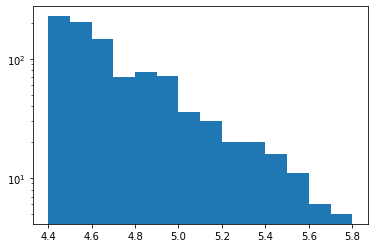

In [297]:
n, bins, patches = plt.hist(list_mags, np.arange(4.4, 5.9, 0.1))
plt.yscale('log')

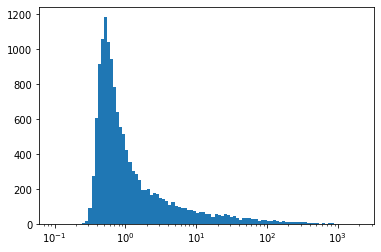

In [251]:
tp_use = []
for i in list_tpmax:
    if i != []:
        for j in i:
            tp_use.append(j)
n, bins, patches = plt.hist(tp_use, np.logspace(-1, 3.3, num=100))
min(tp_use)
max(tp_use)
plt.xscale('log')

In [248]:
max(n)

1185.0

In [16]:
def model_function(x_data, a, b):
    return 10**(a*x_data + b)

In [69]:
def model_function_2(x_data, a, b):
    return a*x_data + b

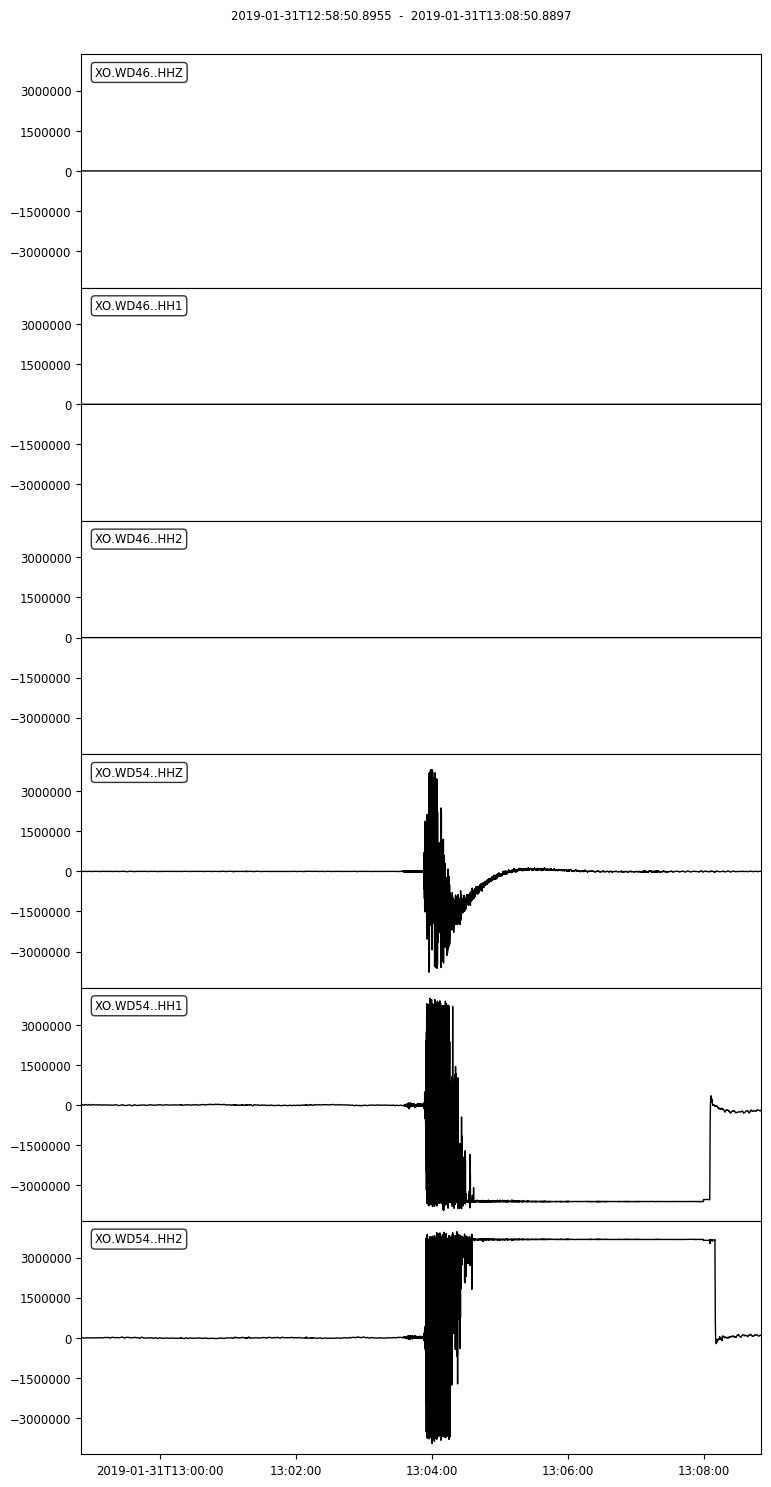

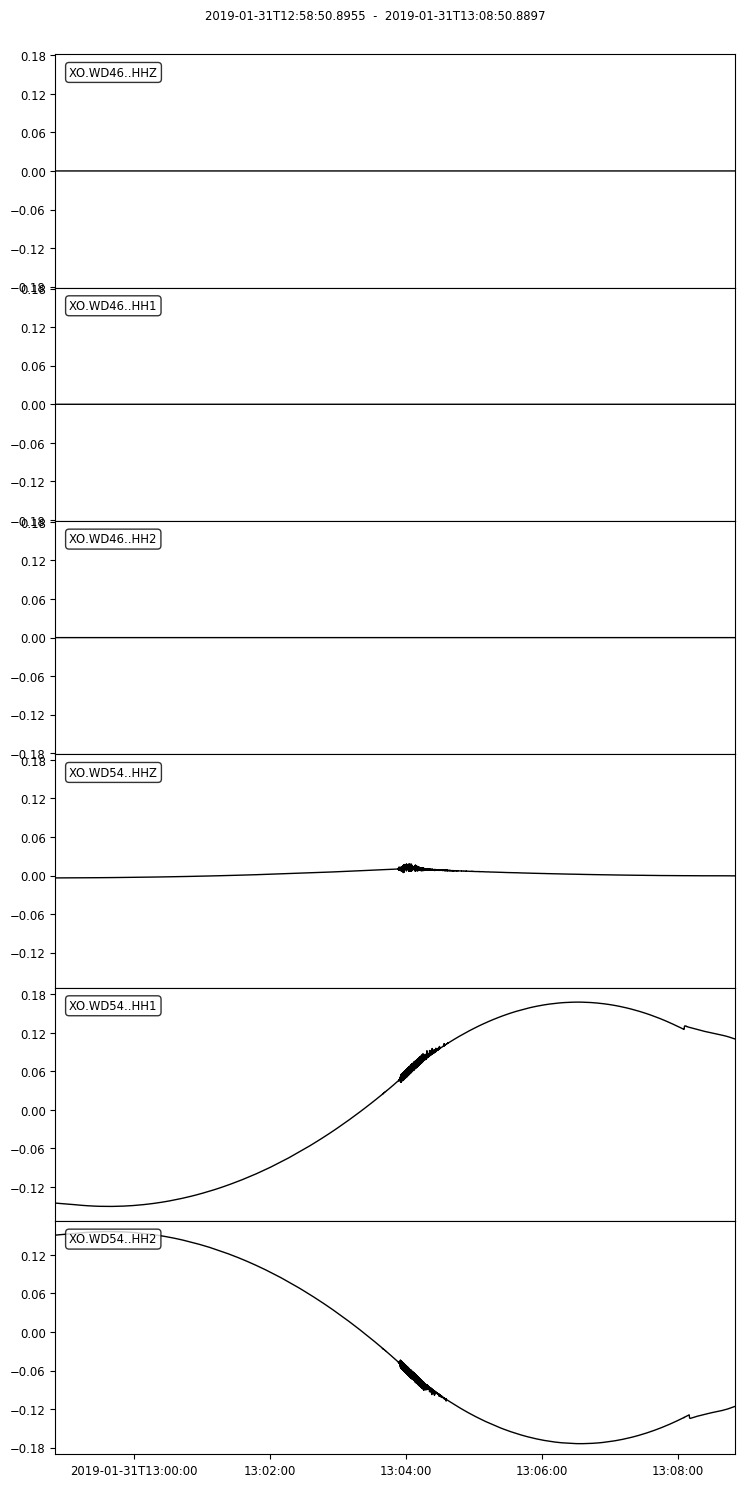

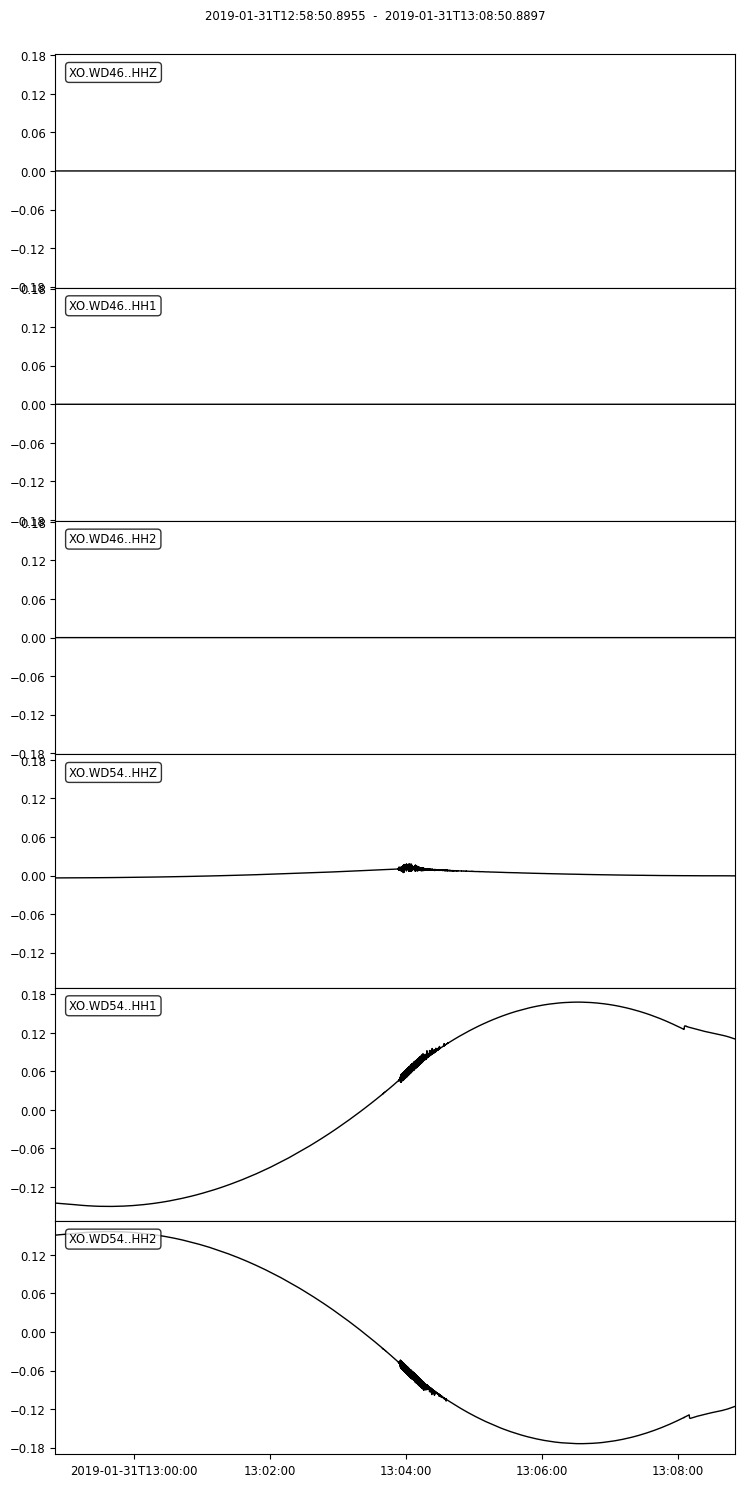

In [224]:
eq_name = '20190131_130350.a'
data = obspy.read(root+eq_name+'/data/*/*')
data.plot()
inv = obspy.read_inventory(root+eq_name+'/station_xml_files/*')
data.remove_response(inv)
data.plot()

plot directly in log space

3.0 [-0.05373754  0.19371219]
3.1 [-0.0099078   0.00359208]
3.2 [ 0.0112921  -0.08945722]
3.3 [ 0.03503982 -0.19479684]
3.4 [ 0.10108819 -0.49033134]
3.5 [ 0.12545105 -0.60019718]
3.6 [ 0.14308981 -0.68051987]
3.7 [ 0.15579013 -0.73869571]
3.8 [ 0.17156315 -0.81137853]
3.9 [ 0.21640409 -1.01979108]
4.0 [ 0.19716481 -0.92955991]
4.1 [ 0.23624592 -1.11484559]
4.2 [ 0.28222822 -1.33566811]
4.3 [ 0.32449775 -1.54202635]
4.4 [ 0.37186854 -1.7772053 ]
4.5 [ 0.41617991 -2.00185092]
4.6 [ 0.53200073 -2.59794732]
4.7 [ 0.60491225 -2.97825302]
4.8 [ 0.63502321 -3.13737367]
4.9 [ 0.55723295 -2.72105359]


Text(0.5, 0.98, 'median = triangle')

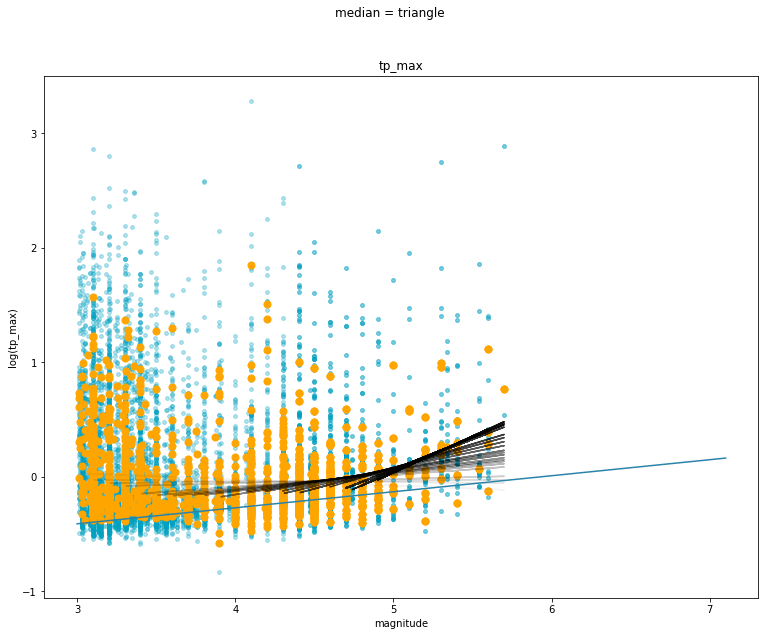

In [330]:

import matplotlib.pyplot as plt
cs = ['#00a1c1']
fig, axs = plt.subplots(1,1, figsize=(12.8,9.6))
y_aves_tp = []
y_aves_tc = []
x_aves_tp = []
x_aves_tc = []
count = 1
eq_count = 0
for mag_lim in np.arange(3, 5, 0.1):
    #print(mag_lim)
    y_aves_tp = []
    y_aves_tc = []
    x_aves_tp = []
    x_aves_tc = []
    for i  in range(0, len(list_mags)):
        if list_mags[i] > mag_lim and list_mags[i]<5.8:
            mean_tp = np.mean(list_tpmax[i]) 
            std_tp = np.std(list_tpmax[i]) 
            y_tp = [] 
            for j in list_tpmax[i]: 
                if j > mean_tp-2*std_tp and j < mean_tp + 2*std_tp:# and j < 4: 
                    y_tp.append(math.log(j, 10)) 
            x_tp = np.zeros(len(y_tp))  
            x_tp = x_tp + list_mags[i]  

            mean_tc = np.mean(list_tc[i]) 
            std_tc = np.std(list_tc[i]) 
            y_tc = [] 
            for k in list_tc[i]: 
                if k > mean_tc-2*std_tc and k < mean_tc + 2*std_tc:# and k < 4: 
                    y_tc.append(math.log(k, 10)) 
            x_tc = np.zeros(len(y_tc))  
            x_tc = x_tc + list_mags[i]
            c = 0
            if str(mag_lim) == str(4.3) or mag_lim == 3:
                #print('in if')
                if len(x_tp)>0 or len(x_tc)>0:
                    if np.median(y_tp):
                        axs.scatter(x_tp, y_tp, s = 15, alpha = 0.3, c = cs[c], marker = 'o', zorder =3) 
                    #axs[0].scatter(list_mags[i], np.mean(y_tp), s = 50, c = cs[c], marker = 'o')
                        axs.scatter(list_mags[i], np.median(y_tp), s = 50, c = 'orange', marker = 'o', zorder =4)
                    #axs[1].scatter(x_tc, y_tc, s = 15, alpha = 0.3, c = cs[c], marker = '^', zorder =3) 
                    #axs[1].scatter(list_mags[i], np.median(y_tc), s = 50, c = cs[c], marker = '^', zorder =4)
                    #axs[1].scatter(list_mags[i], np.mean(y_tc), s = 50, c = cs[c], marker = 'o')
                    #FOR CURVE FITTING
            if math.isnan(np.median(y_tp))==False:
                if np.median(y_tp):
                    y_aves_tp.append(np.median(y_tp))
                    x_aves_tp.append(list_mags[i])
            if math.isnan(np.median(y_tc))==False:
                y_aves_tc.append(np.median(y_tc))
                x_aves_tc.append(list_mags[i])
    popt, pcov = curve_fit(model_function_2, x_aves_tp, y_aves_tp)
    print(mag_lim, popt)
    axs.plot(np.array(x_aves_tp), model_function_2(np.array(x_aves_tp), *popt), color = 'k', alpha = count/21, zorder =10)
    
            # add 2 * std banding
    #axs[0].set_ylim([0.2,2])
    #axs[0].set_yscale('log')
    #axs[1].set_yscale('log')
    count += 1
x = np.arange(3, 7.2, 0.1)
y = 0.14*x-0.83
axs.plot(x, y, color = '#2a83ab', zorder =12)
axs.set_xlabel("magnitude") 
#axs[1].set_xlabel("magnitude") 
axs.set_ylabel("log(tp_max)") 
#axs[1].set_ylabel("tc")
axs.set_title("tp_max") 
#axs[1].set_title("tc") 
fig.suptitle("median = triangle")
#axs.set_ylim(-1, 1)

In [323]:
eq_count = 0
for i  in range(0, len(list_mags)):
    if list_mags[i] > mag_lim and list_mags[i]<5.8:
        eq_count += 1
print(eq_count)

144


In [310]:
f = open('/home/earthquakes1/homes/Rebecca/phd/seismo_det/olson_dataset_csv_gr.csv')
a = f.read()
b = a.split('\n')
c = []
for i in b[1:]:
    if i!='':
        c.append(i.split(','))
m_olsen = []
tp_olsen = []
for j in c:
    if float(j[3]):
        m_olsen.append(float(j[3]))
        tp_olsen.append(math.log(float(j[6]), 10))

In [331]:
axs.scatter(m_olsen, tp_olsen, c = 'k', marker = 'x', zorder = 20)
popt, pcov = curve_fit(model_function_2, m_olsen, tp_olsen)
axs.plot(np.array(m_olsen), model_function_2(np.array(m_olsen), *popt), color = 'k', zorder =10)

[ 0.14058544 -0.79877669]


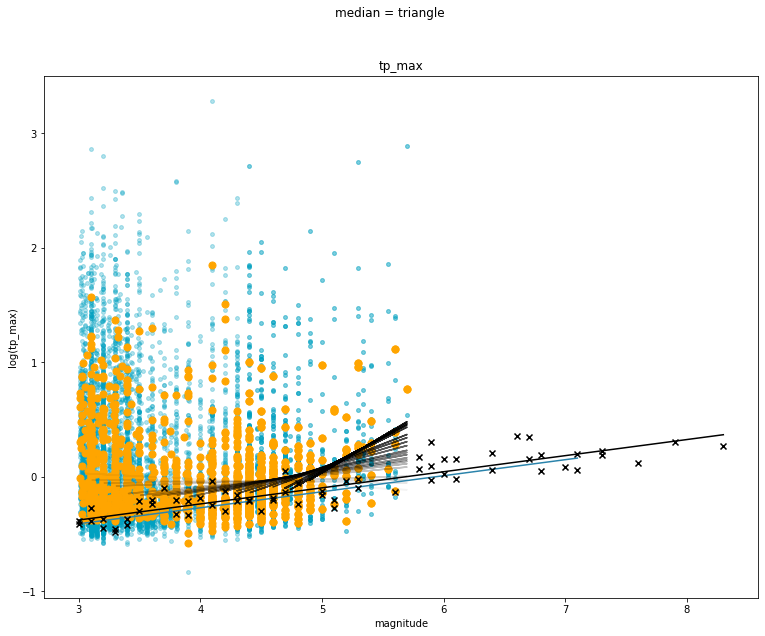

In [332]:
print(popt)
fig

In [256]:
%%capture
#plot line of best fit from olsen and allen 2005
x = np.arange(3, 7.2, 0.1)
x_lower = x - 0.54*2
x_upper =  x + 0.54*2
y = 0.14*x-0.83
y_lower = 0.14*x_lower-0.83
y_upper = 0.14*x_upper-0.83
axs.plot(x, y, color = '#2a83ab', zorder =2)
axs.fill_between(x, y_lower, y_upper, alpha = 0.3, color='coral', zorder =1)
axs.plot(x, y_lower, color = '#2a83ab', linestyle = '--', zorder =2)
axs.plot(x, y_upper, color = '#2a83ab', linestyle = '--', zorder =2)

'''x_lan = np.arange(5, 6, 0.1)
y_lan = 0.34*x_lan-1.8
axs[0].plot(x_lan, y_lan, color = 'magenta', zorder =1)
x_lan_tc_1 = np.arange(5, 6, 0.1) #valid 4--6
x_lan_tc_2 = np.arange(6, 7.2, 0.1) # valid 6--8
y_lan_tc_1 = 0.32*x_lan_tc_1-1.83
y_lan_tc_2 = 0.24*x_lan_tc_2-1.56
axs[1].plot(x_lan_tc_1, y_lan_tc_1, color = 'magenta', zorder =1)
axs[1].plot(x_lan_tc_2, y_lan_tc_2, color = 'magenta', zorder =1)
fig'''

use scipy curve_fit to add my own line of best fit

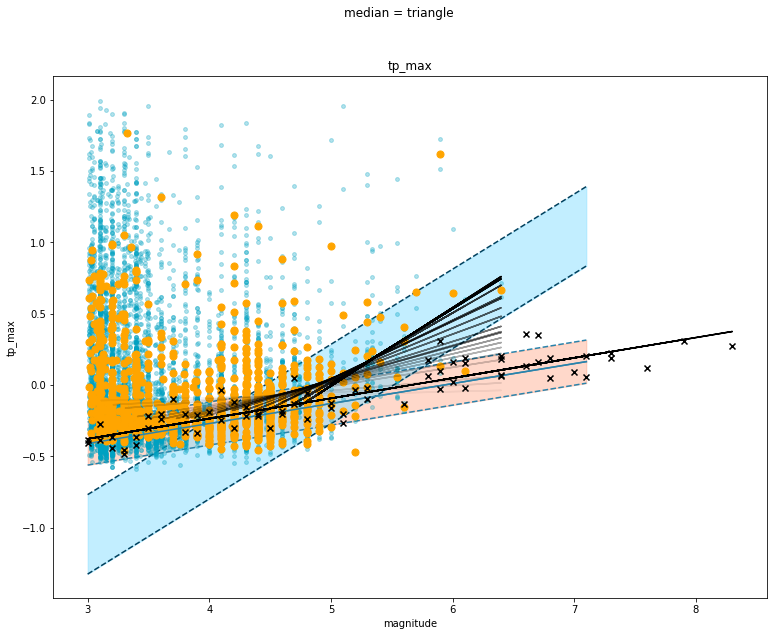

In [257]:
#%%capture
# plot my own line of best fit
popt, pcov = curve_fit(model_function_2, x_aves_tp, y_aves_tp)
axs.plot(np.array(x_aves_tp), model_function_2(np.array(x_aves_tp), *popt), color='#003f5c', zorder =2)

# add 2 * std banding

perr = np.sqrt(np.diag(pcov))
x_me = np.arange(3, 7.2, 0.1)
x_lower_me = x_me - 0.2642707*2
x_upper_me =  x_me + 0.2642707*2
y_me = 0.14*x-0.83
y_lower_me = 0.14*x_lower-0.83
y_upper_me = 0.14*x_upper-0.83
#axs[0].plot(x, y_me, color = '')
axs.fill_between(x_me, model_function_2(np.array(x_lower_me), *popt), model_function_2(np.array(x_upper_me), *popt), color = '#8adfff', alpha = 0.52, zorder =1)
axs.plot(x_me, model_function_2(np.array(x_lower_me), *popt), color = '#003f5c', linestyle = '--', zorder =2)
axs.plot(x_me, model_function_2(np.array(x_upper_me), *popt), color = '#003f5c', linestyle = '--', zorder =2)

fig # show updated figure

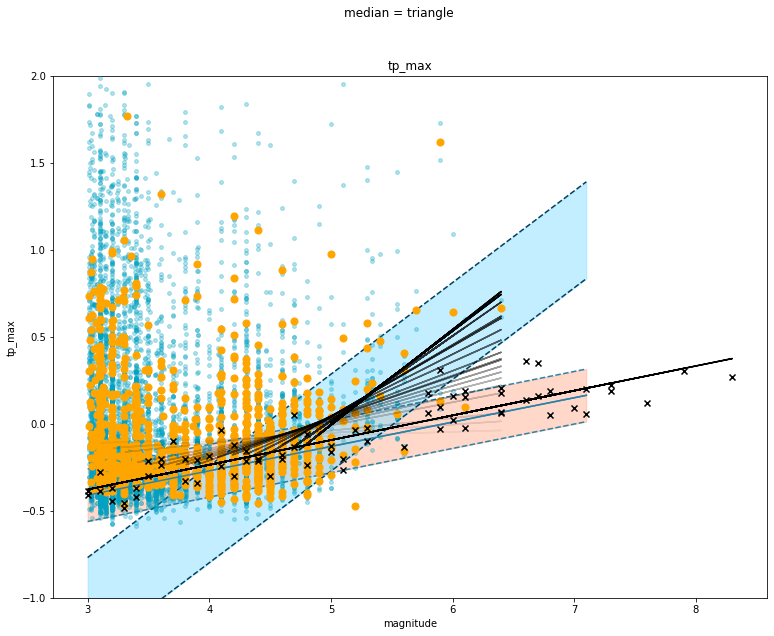

In [258]:
'''# plot my own line of best fit for tc
popt_tc, pcov_tc = curve_fit(model_function_2, x_aves_tc, y_aves_tc)
axs[1].plot(np.array(x_aves_tc), model_function_2(np.array(x_aves_tc), *popt_tc), color='#003f5c', zorder =2)

# add 2 * std banding

perr = np.sqrt(np.diag(pcov_tc))
x_me_tc = np.arange(5, 7.2, 0.1)
x_lower_me_tc = x_me_tc - 0.2642707*2
x_upper_me_tc =  x_me_tc + 0.2642707*2
#y_me_tc = 10**(0.14*x-0.83)
#y_lower_me_tc = 10**(0.14*x_lower-0.83)
#y_upper_me_tc = 10**(0.14*x_upper-0.83)
#axs[0].plot(x, y_me, color = '')
#axs[1].fill_between(x_me_tc, model_function(np.array(x_lower_me_tc), *popt_tc), model_function(np.array(x_upper_me_tc), *popt_tc), color = '#8adfff', alpha = 0.52, zorder =1)
#axs[1].plot(x_me_tc, model_function(np.array(x_lower_me_tc), *popt_tc), color = '#003f5c', linestyle = '--', zorder =2)
#axs[1].plot(x_me_tc, model_function(np.array(x_upper_me_tc), *popt_tc), color = '#003f5c', linestyle = '--', zorder =2)
'''
axs.set_ylim([-1,2])
fig # show updated figure

In [259]:
    mean_tp = np.mean(list_tpmax[i]) 
    std_tp = np.std(list_tpmax[i]) 
    y_tp = [] 
    for j in list_tpmax[i]: 
        if j > mean_tp-std_tp and j < mean_tp + std_tp and j < 10: 
            y_tp.append(math.log(j, 10))

TypeError: list indices must be integers or slices, not str

In [ ]:
list_tpmax[i]

Now I'll plot tpmax and tc on the same graph because the slopes seem very similar so want to check they are a bit different...

In [28]:
%%capture
cs = ['#00a1c1']
fig, axs = plt.subplots(1,1, figsize=(12.8,9.6))
y_aves_tp = []
y_aves_tc = []
x_aves = []
x_aves_tc = []

for i  in range(0, len(list_mags)):  
    mean_tp = np.mean(list_tpmax[i]) 
    std_tp = np.std(list_tpmax[i]) 
    y_tp = [] 
    for j in list_tpmax[i]: 
        if j > mean_tp-std_tp and j < mean_tp + std_tp and j < 10: 
            y_tp.append(j) 
    x_tp = np.zeros(len(y_tp))  
    x_tp = x_tp + list_mags[i]  

    mean_tc = np.mean(list_tc[i]) 
    std_tc = np.std(list_tc[i]) 
    y_tc = [] 
    for k in list_tc[i]: 
        if k > mean_tc-std_tc and k < mean_tc + std_tc and k < 10: 
            y_tc.append(k) 
    x_tc = np.zeros(len(y_tc))  
    x_tc = x_tc + list_mags[i]
    c = 0
    if len(x_tp)>0 or len(x_tc)>0:
        axs.scatter(x_tp, y_tp, s = 15, alpha = 0.3, c = cs[c], marker = '^', zorder =3) 
        #axs[0].scatter(list_mags[i], np.mean(y_tp), s = 50, c = cs[c], marker = 'o')
        axs.scatter(list_mags[i], np.median(y_tp), s = 50, c = cs[c], marker = '^', zorder =4)
        axs.scatter(x_tc, y_tc, s = 15, alpha = 0.3, c = 'coral', marker = '*', zorder =3) 
        axs.scatter(list_mags[i], np.median(y_tc), s = 50, c = 'coral', marker = '*', zorder =4)
        #axs[1].scatter(list_mags[i], np.mean(y_tc), s = 50, c = cs[c], marker = 'o')
        #FOR CURVE FITTING
        if math.isnan(np.median(y_tp))==False:
            y_aves_tp.append(np.median(y_tp))
            x_aves.append(list_mags[i])
        if math.isnan(np.median(y_tc))==False:
            y_aves_tc.append(np.median(y_tc))
            x_aves_tc.append(list_mags[i])

axs.set_yscale('log')
axs.set_xlabel("magnitude") 
axs.set_ylabel("tp_max (^), tc (*)") 
fig.suptitle("median = triangle")

In [29]:
%%capture
# plot my own line of best fit
popt, pcov = curve_fit(model_function, x_aves, y_aves_tp)
axs.plot(np.array(x_aves), model_function(np.array(x_aves), *popt), color='#008bad', zorder =2)

# add 2 * std banding

perr = np.sqrt(np.diag(pcov))
x_me = np.arange(5, 7.2, 0.1)
x_lower_me = x_me - 0.2642707*2
x_upper_me =  x_me + 0.2642707*2
y_me = 10**(0.14*x-0.83)
y_lower_me = 10**(0.14*x_lower-0.83)
y_upper_me = 10**(0.14*x_upper-0.83)
#axs[0].plot(x, y_me, color = '')
#axs.fill_between(x, model_function(np.array(x_lower_me), *popt), model_function(np.array(x_upper_me), *popt), color = '#8adfff', alpha = 0.52, zorder =1)
axs.plot(x, model_function(np.array(x_lower_me), *popt), color = '#008bad', linestyle = '--', zorder =2)
axs.plot(x, model_function(np.array(x_upper_me), *popt), color = '#008bad', linestyle = '--', zorder =2)

# fig # show updated figure

ValueError: x and y must have same first dimension, but have shapes (42,) and (22,)

In [30]:
# plot my own line of best fit for tc
popt_tc, pcov_tc = curve_fit(model_function, x_aves_tc, y_aves_tc)
axs.plot(np.array(x_aves), model_function(np.array(x_aves), *popt_tc), color='coral', zorder =2)

# add 2 * std banding

perr = np.sqrt(np.diag(pcov_tc))
x_me_tc = np.arange(5, 7.2, 0.1)
x_lower_me_tc = x_me_tc - 0.2642707*2
x_upper_me_tc =  x_me_tc + 0.2642707*2
#y_me_tc = 10**(0.14*x-0.83)
#y_lower_me_tc = 10**(0.14*x_lower-0.83)
#y_upper_me_tc = 10**(0.14*x_upper-0.83)
#axs[0].plot(x, y_me, color = '')
#axs.fill_between(x, model_function(np.array(x_lower_me_tc), *popt_tc), model_function(np.array(x_upper_me_tc), *popt_tc), color = '#8adfff', alpha = 0.52, zorder =1)
axs.plot(x, model_function(np.array(x_lower_me_tc), *popt_tc), color = 'coral', linestyle = '--', zorder =2)
axs.plot(x, model_function(np.array(x_upper_me_tc), *popt_tc), color = 'coral', linestyle = '--', zorder =2)

fig # show updated figure

ValueError: x and y must have same first dimension, but have shapes (42,) and (22,)

They are different, yay! 


In [ ]:
# %%script false --no-raise-error
fig.savefig('/home/earthquakes1/homes/Rebecca/phd/seismo_det/figures/tp_and_tc/2019_m3_plus.png', transparent=True)

### importance of filtering
turns out i only highpass filter if have acceleration data, so don't need this...

In [ ]:
%%script false --no-raise-error
list_tpmax_2 = []
list_mags_2 = []
list_tc_2= []
eqs_2 = {}
count = 0
for eq_name in eq_with_data:
    
    d = util.filenameToDate(eq_name)
    
    filter_start = str(UTCDateTime(d-timedelta(seconds=1)))
    filter_stop = str(UTCDateTime(d+timedelta(seconds=1)))
    
    event = cat.filter('time > ' + filter_start, 'time < ' + filter_stop)
    # print(event)
    data = obspy.read(root+eq_name+'/data/*/*')
    with open(root+eq_name+'/picks.pkl', 'rb') as f:
        picks = pickle.load(f)
    obj_name = eq_name[0:-2]
    eqs_2[obj_name] = earthquake(eq_name, event, data, picks, sensor_types = [])
    eqs_2[obj_name].calc_Tpmax(freq_cut_off=0.01, filter_corners = 4)
    eqs_2[obj_name].calc_Tc()
    list_tpmax_2.append(eqs[obj_name]._cached_params["tau_p_max"])
    list_tc_2.append(eqs[obj_name]._cached_params["tau_c"])
    list_mags_2.append(eqs[obj_name].event.magnitudes[0].mag)
    print('earthquake number ' + str(count) + ' done. It was ' + eq_name)
    count += 1

In [ ]:
%%script false --no-raise-error
cs = ['#000000']
fig, axs = plt.subplots(1,2, figsize=(12.8,9.6))
y_aves = []
x_aves = []
y_aves_2 = []
x_aves_2 = []
for i  in range(0, len(list_mags)):  
    mean_tp = np.mean(list_tpmax[i]) 
    std_tp = np.std(list_tpmax[i]) 
    y_tp = [] 
    for j in list_tpmax[i]: 
        if j > mean_tp-std_tp and j < mean_tp + std_tp and j < 10: 
            y_tp.append(j) 
    x_tp = np.zeros(len(y_tp))  
    x_tp = x_tp + list_mags[i]  

    mean_tp_2 = np.mean(list_tpmax_2[i]) 
    std_tp_2 = np.std(list_tpmax_2[i]) 
    y_tp_2 = [] 
    for j in list_tpmax_2[i]: 
        if j > mean_tp_2-std_tp_2 and j < mean_tp_2 + std_tp_2 and j < 10: 
            y_tp_2.append(j) 
    x_tp_2 = np.zeros(len(y_tp))  
    x_tp_2 = x_tp_2 + list_mags_2[i] 
    c = 0
    if len(x_tp)>0 or len(x_tp_2)>0:
        axs[0].scatter(x_tp, y_tp, s = 15, alpha = 0.2, c = cs[c], marker = '^') 
        #axs[0].scatter(list_mags[i], np.mean(y_tp), s = 50, c = cs[c], marker = 'o')
        axs[0].scatter(list_mags[i], np.median(y_tp), s = 50, c = cs[c], marker = '^')
        axs[1].scatter(x_tp_2, y_tp_2, s = 15, alpha = 0.2, c = cs[c], marker = '^') 
        axs[1].scatter(list_mags_2[i], np.median(y_tp_2), s = 50, c = cs[c], marker = '^')
        #axs[1].scatter(list_mags[i], np.mean(y_tc), s = 50, c = cs[c], marker = 'o')
        #FOR CURVE FITTING
        if math.isnan(np.median(y_tp))==False:
            y_aves.append(np.median(y_tp))
            x_aves.append(list_mags[i])
        if math.isnan(np.median(y_tp_2))==False:
            y_aves_2.append(np.median(y_tp_2))
            x_aves_2.append(list_mags_2[i])

axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[0].set_xlabel("magnitude") 
axs[1].set_xlabel("magnitude") 
axs[0].set_ylabel("tp_max") 
axs[1].set_ylabel("tc")
axs[0].set_title("tp_max") 
axs[1].set_title("tc") 
fig.suptitle("median = triangle")

add line of best fit from olsen and allen 2005, with 2x absolute deviation band

In [ ]:
%%script false --no-raise-error
#plot line of best fit from olsen and allen 2005
x = np.arange(5, 7.2, 0.1)
x_lower = x - 0.54*2
x_upper =  x + 0.54*2
y = 10**(0.14*x-0.83)
y_lower = 10**(0.14*x_lower-0.83)
y_upper = 10**(0.14*x_upper-0.83)
axs[0].plot(x, y, color = 'red')
axs[0].plot(x, y_lower, color = 'red', linestyle = '--')
axs[0].plot(x, y_upper, color = 'red', linestyle = '--')
fig

use scipy curve_fit to add my own line of best fit

In [ ]:
%%script false --no-raise-error
# plot my own line of best fit
popt, pcov = curve_fit(model_function, x_aves, y_aves)
axs[0].plot(np.array(x_aves), model_function(np.array(x_aves), *popt), color='blue')

# add 2 * std banding

perr = np.sqrt(np.diag(pcov))
x_me = np.arange(5, 7.2, 0.1)
x_lower_me = x_me - 0.2642707*2
x_upper_me =  x_me + 0.2642707*2
y_me = 10**(0.14*x-0.83)
y_lower_me = 10**(0.14*x_lower-0.83)
y_upper_me = 10**(0.14*x_upper-0.83)
axs[0].plot(x, y_me, color = 'red')
axs[0].plot(x, model_function(np.array(x_lower_me), *popt), color = 'blue', linestyle = '--')
axs[0].plot(x, model_function(np.array(x_upper_me), *popt), color = 'blue', linestyle = '--')

fig # show updated figure

In [ ]:
%%script false --no-raise-error
# plot my own line of best fit
popt_2, pcov_2 = curve_fit(model_function, x_aves_2, y_aves_2)
axs[1].plot(np.array(x_aves_2), model_function(np.array(x_aves_2), *popt_2), color='green')

# add 2 * std banding

perr_2 = np.sqrt(np.diag(pcov_2))
x_me_2 = np.arange(5, 7.2, 0.1)
x_lower_me_2 = x_me_2 - 0.2642707*2
x_upper_me_2 =  x_me_2 + 0.2642707*2
y_me_2 = 10**(0.14*x-0.83)
y_lower_me_2 = 10**(0.14*x_lower-0.83)
y_upper_me_2 = 10**(0.14*x_upper-0.83)
axs[1].plot(x_me_2, y_me_2, color = 'red')
axs[1].plot(x_me_2, model_function(np.array(x_lower_me_2), *popt_2), color = 'green', linestyle = '--')
axs[1].plot(x_me_2, model_function(np.array(x_upper_me_2), *popt_2), color = 'green', linestyle = '--')

fig # show updated figure